In [1]:
import pandas as pd
import numpy as np

PATH = "/content"  # o tu carpeta en Drive

df_clean = pd.read_csv(f"{PATH}/df_clean.csv")
df_invoices = pd.read_csv(f"{PATH}/df_invoices.csv")
df_customers = pd.read_csv(f"{PATH}/df_customers.csv")
df_segmentation = pd.read_csv(f"{PATH}/df_segmentation.csv")

# fechas
df_clean["invoice_date"] = pd.to_datetime(df_clean["invoice_date"], errors="coerce")
df_invoices["invoice_date"] = pd.to_datetime(df_invoices["invoice_date"], errors="coerce")
df_customers["last_purchase"] = pd.to_datetime(df_customers["last_purchase"], errors="coerce")
df_customers["first_purchase"] = pd.to_datetime(df_customers["first_purchase"], errors="coerce")

(df_clean.shape, df_invoices.shape, df_customers.shape, df_segmentation.shape)


((1055238, 11), (36975, 6), (5942, 28), (812368, 13))

In [2]:
print("Periodos en df_clean:", df_clean["period"].value_counts(dropna=False))
print("Rango fechas df_clean:", df_clean["invoice_date"].min(), "->", df_clean["invoice_date"].max())

print("\n% líneas con customer_id nulo (df_clean):", df_clean["customer_id"].isna().mean())
print("% líneas marcadas como devolución (df_clean):", df_clean["is_return"].mean())

print("\nClientes únicos (df_customers):", df_customers["customer_id"].nunique())
print("Clientes únicos (df_clean, con id):", df_clean.loc[df_clean["customer_id"].notna(), "customer_id"].nunique())


Periodos en df_clean: period
2010-2011    536642
2009-2010    518596
Name: count, dtype: int64
Rango fechas df_clean: 2009-12-01 07:45:00 -> 2011-12-09 12:50:00

% líneas con customer_id nulo (df_clean): 0.23015660921991057
% líneas marcadas como devolución (df_clean): 0.021691788961352796

Clientes únicos (df_customers): 5942
Clientes únicos (df_clean, con id): 5942


In [3]:
import pandas as pd
import numpy as np

# Aseguramos revenue (si ya existe, no lo toca)
if "revenue" not in df_clean.columns:
    df_clean["revenue"] = df_clean["quantity"] * df_clean["price"]

# Aseguramos tipos
df_clean["invoice_date"] = pd.to_datetime(df_clean["invoice_date"], errors="coerce")


In [4]:
import pandas as pd
import numpy as np

def build_customer_features(df_lines: pd.DataFrame, period_label: str) -> pd.DataFrame:
    """
    Construye un dataset a nivel cliente para un periodo dado, usando df_clean.
    - Detecta automáticamente el nombre de la columna de factura (invoice vs invoice_no).
    - Trata is_return como booleano.
    - Monetary/AOV y métricas por pedido se calculan SOLO sobre compras (no devoluciones).
    - Las devoluciones se capturan como ratios separados.
    """

    d = df_lines.copy()

    # Detectar nombre de columna de factura
    invoice_col = "invoice" if "invoice" in d.columns else "invoice_no"
    stock_col = "stock_code"
    date_col = "invoice_date"
    cust_col = "customer_id"
    rev_col = "revenue"
    qty_col = "quantity"
    ret_col = "is_return"

    # Filtrar clientes identificados
    d = d[d[cust_col].notna()].copy()
    d[cust_col] = d[cust_col].astype(int)

    # Normalizar invoice a string (evita problemas por mezcla int/str, especialmente con devoluciones "C...")
    d[invoice_col] = d[invoice_col].astype(str)

    # Tipos
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d[ret_col] = d[ret_col].astype(bool)

    # Fin de periodo para recency
    period_end = d[date_col].max()

    # Máscaras
    is_return = d[ret_col]
    is_purchase = ~is_return

    # --- Invoice-level (solo compras) ---
    inv = (
        d[is_purchase]
        .groupby([cust_col, invoice_col], as_index=False)
        .agg(
            invoice_date=(date_col, "max"),
            invoice_revenue=(rev_col, "sum"),
            invoice_qty=(qty_col, "sum"),
            invoice_lines=(stock_col, "size"),  # nº líneas (items) en la factura
        )
    )

    inv["is_weekend"] = inv["invoice_date"].dt.dayofweek >= 5

    # --- Customer-level (compras) ---
    cust = (
        inv.groupby(cust_col)
        .agg(
            frequency=(invoice_col, "nunique"),
            monetary=("invoice_revenue", "sum"),
            avg_order_value=("invoice_revenue", "mean"),
            avg_items_per_invoice=("invoice_qty", "mean"),
            avg_lines_per_invoice=("invoice_lines", "mean"),
            last_purchase=("invoice_date", "max"),
            first_purchase=("invoice_date", "min"),
            weekend_ratio=("is_weekend", "mean"),
        )
        .reset_index()
    )

    cust["recency_days"] = (period_end - cust["last_purchase"]).dt.days

    # Variety (U): nº productos distintos comprados en el periodo (solo compras)
    variety = (
        d[is_purchase]
        .groupby(cust_col)[stock_col]
        .nunique()
        .reset_index(name="variety_u")
    )
    cust = cust.merge(variety, on=cust_col, how="left")

    # --- Interpurchase (avg days between purchases) ---
    inv_sorted = inv.sort_values([cust_col, "invoice_date"]).copy()
    inv_sorted["delta_days"] = inv_sorted.groupby(cust_col)["invoice_date"].diff().dt.days

    avg_days = inv_sorted.groupby(cust_col)["delta_days"].mean().reset_index(name="avg_days_between_purchases")
    cust = cust.merge(avg_days, on=cust_col, how="left")

    # --- Returns ratio (líneas) sobre TODAS las líneas (compras + devoluciones) ---
    returns_stats = d.groupby(cust_col).agg(
        total_lines=(stock_col, "size"),
        return_lines=(ret_col, "sum"),  # suma de True
    ).reset_index()

    returns_stats["return_ratio_lines"] = returns_stats["return_lines"] / returns_stats["total_lines"]
    cust = cust.merge(returns_stats[[cust_col, "return_ratio_lines"]], on=cust_col, how="left")

    # --- Return ratio revenue (opcional) ---
    purchase_rev = d[is_purchase].groupby(cust_col)[rev_col].sum().reset_index(name="purchase_revenue")
    # revenue en devoluciones es negativo; lo pasamos a positivo para ratio
    return_rev_abs = (-d[is_return].groupby(cust_col)[rev_col].sum()).reset_index(name="return_revenue_abs")

    tmp = purchase_rev.merge(return_rev_abs, on=cust_col, how="left").fillna({"return_revenue_abs": 0.0})
    tmp["return_ratio_revenue"] = np.where(tmp["purchase_revenue"] > 0,
                                          tmp["return_revenue_abs"] / tmp["purchase_revenue"],
                                          np.nan)

    cust = cust.merge(tmp[[cust_col, "return_ratio_revenue"]], on=cust_col, how="left")

    cust["period"] = period_label
    return cust



In [5]:
df_train_lines = df_clean[df_clean["period"] == "2009-2010"].copy()
df_test_lines  = df_clean[df_clean["period"] == "2010-2011"].copy()

df_customers_train = build_customer_features(df_train_lines, "2009-2010")
df_customers_test  = build_customer_features(df_test_lines,  "2010-2011")

(df_customers_train.shape, df_customers_test.shape)


((4314, 15), (4339, 15))

In [6]:
print("Clientes train:", df_customers_train["customer_id"].nunique())
print("Clientes test:",  df_customers_test["customer_id"].nunique())

overlap = set(df_customers_train["customer_id"]) & set(df_customers_test["customer_id"])
print("Clientes presentes en ambos periodos:", len(overlap))

df_customers_train.head()


Clientes train: 4314
Clientes test: 4339
Clientes presentes en ambos periodos: 2772


,customer_id,frequency,monetary,avg_order_value,avg_items_per_invoice,avg_lines_per_invoice,last_purchase,first_purchase,weekend_ratio,recency_days,variety_u,avg_days_between_purchases,return_ratio_lines,return_ratio_revenue,period
0,12346,11,372.86,33.896364,6.363636,3.0,2010-06-28 13:53:00,2009-12-14 08:34:00,0.0,164,26,19.2,0.266667,1.138765,2009-2010
1,12347,2,1323.32,661.660000,414.000000,35.5,2010-12-07 14:57:00,2010-10-31 14:20:00,0.5,2,70,37.0,0.000000,0.000000,2009-2010
2,12348,1,222.16,222.160000,373.000000,20.0,2010-09-27 14:59:00,2010-09-27 14:59:00,0.0,73,20,NaN,0.000000,0.000000,2009-2010
3,12349,3,2671.14,890.380000,331.000000,34.0,2010-10-28 08:23:00,2010-04-29 13:20:00,0.0,42,90,90.0,0.046729,0.009041,2009-2010
4,12351,1,300.93,300.930000,261.000000,21.0,2010-11-29 15:23:00,2010-11-29 15:23:00,0.0,10,21,NaN,0.000000,0.000000,2009-2010


In [7]:
df_customers_train[
    ["recency_days","frequency","monetary","variety_u","avg_order_value",
     "avg_items_per_invoice","avg_lines_per_invoice","return_ratio_lines",
     "avg_days_between_purchases","weekend_ratio"]
].describe().T


,count,mean,std,min,25%,50%,75%,max
recency_days,4314.0,90.269124,96.943482,0.0,17.000000,52.000000,135.000000,373.000000
frequency,4314.0,4.454103,8.168658,1.0,1.000000,2.000000,5.000000,205.000000
monetary,4314.0,2039.460766,8909.797773,0.0,307.105000,700.405000,1713.297500,349164.350000
variety_u,4314.0,63.618220,85.753098,1.0,17.000000,38.000000,79.000000,1741.000000
avg_order_value,4314.0,376.198874,492.309973,0.0,179.400000,284.855000,421.450000,11880.840000
avg_items_per_invoice,4314.0,254.533803,1553.751540,1.0,89.000000,150.854167,255.000000,87167.000000
avg_lines_per_invoice,4314.0,21.679250,18.344785,1.0,9.773352,17.500000,27.592857,236.000000
return_ratio_lines,4314.0,0.027811,0.071636,0.0,0.000000,0.000000,0.024390,0.755102
avg_days_between_purchases,2893.0,69.671665,62.072092,0.0,28.000000,51.500000,89.500000,361.000000
weekend_ratio,4314.0,0.148288,0.281290,0.0,0.000000,0.000000,0.166667,1.000000


In [8]:
features = [
    "recency_days",
    "frequency",
    "monetary",
    "variety_u",
    "avg_order_value",
    "avg_items_per_invoice",
    "avg_lines_per_invoice",
    "return_ratio_lines",
    "avg_days_between_purchases",
    "weekend_ratio"
]

# Variables muy sesgadas donde el log ayuda mucho
log_features = [
    "frequency",
    "monetary",
    "variety_u",
    "avg_order_value",
    "avg_items_per_invoice",
    "avg_lines_per_invoice",
    "avg_days_between_purchases"
]


In [9]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def preprocess_fit(df, features, log_features=None, cap_q=0.99):
    X = df[features].copy()

    # 1) imputación mediana
    imputer = SimpleImputer(strategy="median")
    X_imp = pd.DataFrame(imputer.fit_transform(X), columns=features)

    # 2) capado superior p99 (winsor)
    caps = X_imp.quantile(cap_q)
    X_cap = X_imp.clip(upper=caps, axis=1)

    # 3) log1p en variables sesgadas
    if log_features:
        for c in log_features:
            X_cap[c] = np.log1p(X_cap[c])

    # 4) escalado
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cap)

    return imputer, caps, scaler, X_scaled, X_cap

def preprocess_transform(df, features, imputer, caps, scaler, log_features=None):
    X = df[features].copy()
    X_imp = pd.DataFrame(imputer.transform(X), columns=features)
    X_cap = X_imp.clip(upper=caps, axis=1)

    if log_features:
        for c in log_features:
            X_cap[c] = np.log1p(X_cap[c])

    X_scaled = scaler.transform(X_cap)
    return X_scaled, X_cap


In [10]:
print("df_customers_train:", df_customers_train.shape)
print("df_customers_test :", df_customers_test.shape)

# 10 features esperadas
print("n_features:", len(features))
print("features:", features)

X_test_raw = df_customers_test[features].copy()
print("X_test_raw:", X_test_raw.shape)

# ¿Cuántas filas sobreviven si haces dropna total?
print("X_test_raw.dropna():", X_test_raw.dropna().shape)

# % nulos por feature en test
display((X_test_raw.isna().mean()*100).sort_values(ascending=False).round(2))


df_customers_train: (4314, 15)
df_customers_test : (4339, 15)
n_features: 10
features: ['recency_days', 'frequency', 'monetary', 'variety_u', 'avg_order_value', 'avg_items_per_invoice', 'avg_lines_per_invoice', 'return_ratio_lines', 'avg_days_between_purchases', 'weekend_ratio']
X_test_raw: (4339, 10)
X_test_raw.dropna(): (2845, 10)


,0
avg_days_between_purchases,34.43
recency_days,0.00
frequency,0.00
monetary,0.00
avg_order_value,0.00
variety_u,0.00
avg_items_per_invoice,0.00
avg_lines_per_invoice,0.00
return_ratio_lines,0.00
weekend_ratio,0.00


In [11]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def preprocess_fit(df, features, log_features=None, cap_q=0.99):
    X = df[features].copy()

    # 1) Limpiar inf
    X = X.replace([np.inf, -np.inf], np.nan)

    # 2) Imputación
    imputer = SimpleImputer(strategy="median")
    X_imp = pd.DataFrame(imputer.fit_transform(X), columns=features, index=df.index)

    # 3) Log1p SOLO si la columna es no-negativa
    safe_log = []
    skipped_log = []
    if log_features is None:
        log_features = []
    for col in log_features:
        if X_imp[col].min() >= 0:
            X_imp[col] = np.log1p(X_imp[col])
            safe_log.append(col)
        else:
            skipped_log.append(col)

    # 4) Capping (winsorización) por cuantiles
    caps = {}
    lo_q = 1 - cap_q
    for col in features:
        lo = X_imp[col].quantile(lo_q)
        hi = X_imp[col].quantile(cap_q)
        caps[col] = (lo, hi)
        X_imp[col] = X_imp[col].clip(lo, hi)

    # 5) Escalado
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imp)

    # Guardar qué logs se aplicaron para usar igual en test
    scaler.safe_log_features = safe_log
    scaler.skipped_log_features = skipped_log

    # Seguridad final: no finitos
    X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

    print("Log aplicado a:", safe_log)
    if skipped_log:
        print("Log omitido (negativos detectados):", skipped_log)

    return imputer, caps, scaler, X_scaled, X_imp


def preprocess_transform(df, features, imputer, caps, scaler, log_features=None):
    X = df[features].copy()
    X = X.replace([np.inf, -np.inf], np.nan)

    X_imp = pd.DataFrame(imputer.transform(X), columns=features, index=df.index)

    # Aplicar exactamente los mismos logs que en fit
    safe_log = getattr(scaler, "safe_log_features", []) if log_features is None else log_features
    for col in safe_log:
        # aquí safe_log ya garantiza no-negativo en train; por seguridad clip en 0
        X_imp[col] = np.log1p(np.clip(X_imp[col], a_min=0, a_max=None))

    # Capping con los mismos límites del train
    for col, (lo, hi) in caps.items():
        X_imp[col] = X_imp[col].clip(lo, hi)

    X_scaled = scaler.transform(X_imp)
    X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)

    return X_scaled, X_imp



In [12]:

# CONFIGURACIÓN FIJA

import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

KMEANS_K = 4
KMEANS_N_INIT = 50

GMM_K = 4
GMM_COV = "full"

DBSCAN_EPS = 1.2
DBSCAN_MIN_SAMPLES = 10


In [13]:
imputer, caps, scaler, X_train_scaled, X_train_pre = preprocess_fit(
    df_customers_train, features, log_features=log_features, cap_q=0.99
)

X_test_scaled, X_test_pre = preprocess_transform(
    df_customers_test, features, imputer, caps, scaler, log_features=log_features
)

X_train_scaled.shape, X_test_scaled.shape


Log aplicado a: ['frequency', 'monetary', 'variety_u', 'avg_order_value', 'avg_items_per_invoice', 'avg_lines_per_invoice', 'avg_days_between_purchases']


((4314, 10), (4339, 10))

In [14]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

Xtr = X_train_scaled

# KMeans (k=4) - FIJO
kmeans = KMeans(n_clusters=KMEANS_K, random_state=SEED, n_init=KMEANS_N_INIT)
labels_km_tr = kmeans.fit_predict(Xtr)

# GMM (k=4) - FIJO
gmm = GaussianMixture(n_components=GMM_K, random_state=SEED, covariance_type=GMM_COV)
labels_gmm_tr = gmm.fit_predict(Xtr)

# DBSCAN (eps=1.2, min_samples=10) - FIJO
db = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES)
labels_db_tr = db.fit_predict(Xtr)

print("KMeans counts:", pd.Series(labels_km_tr).value_counts().sort_index().to_dict())
print("GMM counts   :", pd.Series(labels_gmm_tr).value_counts().sort_index().to_dict())
print("DBSCAN counts:", pd.Series(labels_db_tr).value_counts().sort_index().to_dict())


KMeans counts: {0: 940, 1: 498, 2: 1628, 3: 1248}
GMM counts   : {0: 2025, 1: 385, 2: 751, 3: 1153}
DBSCAN counts: {-1: 755, 0: 3559}


In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

Xte = X_test_scaled

# Predicción en test (NO refit)
labels_km_te  = kmeans.predict(Xte)
labels_gmm_te = gmm.predict(Xte)

# Métricas internas en test
tabla_metricas_test = pd.DataFrame([
    {
        "Modelo": "KMeans (k=4) [test]",
        "n_clusters": len(np.unique(labels_km_te)),
        "n_noise": 0,
        "Silhouette": silhouette_score(Xte, labels_km_te),
        "Calinski-Harabasz": calinski_harabasz_score(Xte, labels_km_te),
        "Davies-Bouldin": davies_bouldin_score(Xte, labels_km_te)
    },
    {
        "Modelo": "GMM (k=4) [test]",
        "n_clusters": len(np.unique(labels_gmm_te)),
        "n_noise": 0,
        "Silhouette": silhouette_score(Xte, labels_gmm_te),
        "Calinski-Harabasz": calinski_harabasz_score(Xte, labels_gmm_te),
        "Davies-Bouldin": davies_bouldin_score(Xte, labels_gmm_te)
    }
]).round(4)

tabla_metricas_test


,Modelo,n_clusters,n_noise,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,KMeans (k=4) [test],4,0,0.1923,959.1082,1.5538
1,GMM (k=4) [test],4,0,0.1054,397.0435,3.0426


In [16]:
pd.DataFrame({"cap_p99": caps}).T


,recency_days,frequency,monetary,variety_u,avg_order_value,avg_items_per_invoice,avg_lines_per_invoice,return_ratio_lines,avg_days_between_purchases,weekend_ratio
cap_p99,"(0.0, 367.0)","(0.6931471805599453, 3.4657359027997265)","(3.7125104436317584, 9.903707171105907)","(0.6931471805599453, 5.964806521068039)","(3.5267423163736917, 7.578384949885771)","(1.6094379124341003, 7.197618210964894)","(0.6931471805599453, 4.492294398947507)","(0.0, 0.4)","(0.0, 5.672875762426666)","(0.0, 1.0)"


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

results = []
Ks = range(3, 11)  # 3 a 10 suele ser rango razonable para 4-6 segmentos finales

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_train_scaled)

    results.append({
        "k": k,
        "inertia": km.inertia_,
        "silhouette": silhouette_score(X_train_scaled, labels),
        "calinski_harabasz": calinski_harabasz_score(X_train_scaled, labels),
        "davies_bouldin": davies_bouldin_score(X_train_scaled, labels)
    })

df_k = pd.DataFrame(results).sort_values("k")
df_k


,k,inertia,silhouette,calinski_harabasz,davies_bouldin
0,3,29833.764365,0.229623,961.394724,1.486707
1,4,26214.223462,0.177270,927.615256,1.591860
2,5,24281.575025,0.158268,836.658738,1.712638
3,6,21727.454013,0.177727,849.113411,1.512418
4,7,20262.534891,0.170363,810.471500,1.498289
5,8,19305.663137,0.179390,759.447938,1.449151
6,9,18491.318421,0.168011,717.313470,1.557869
7,10,17704.743685,0.163724,687.030833,1.516214


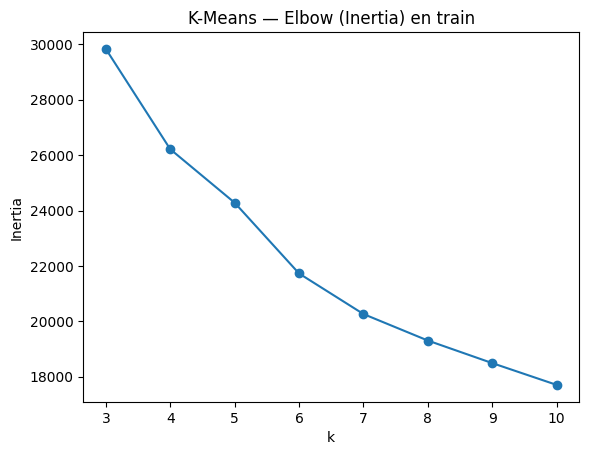

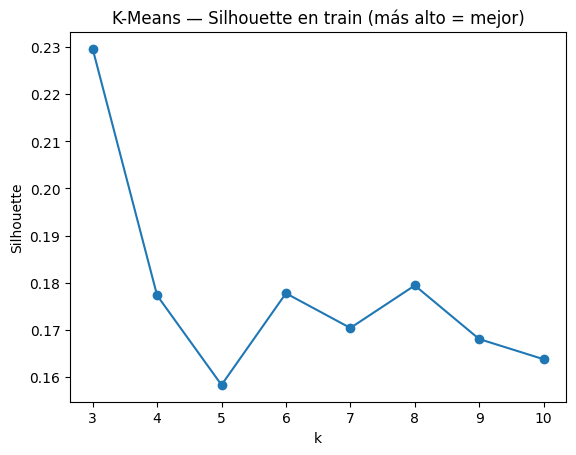

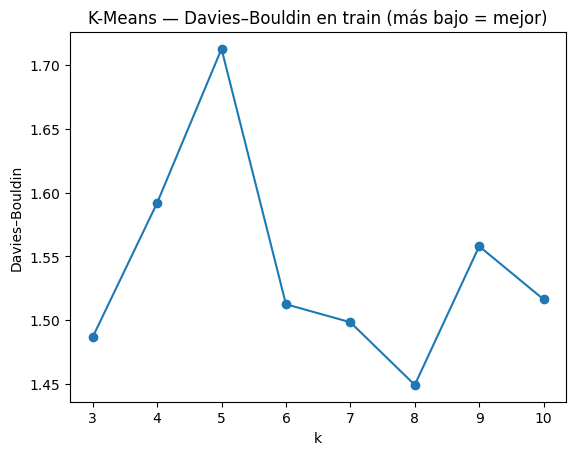

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_k["k"], df_k["inertia"], marker="o")
plt.title("K-Means — Elbow (Inertia) en train")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.show()

plt.figure()
plt.plot(df_k["k"], df_k["silhouette"], marker="o")
plt.title("K-Means — Silhouette en train (más alto = mejor)")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.show()

plt.figure()
plt.plot(df_k["k"], df_k["davies_bouldin"], marker="o")
plt.title("K-Means — Davies–Bouldin en train (más bajo = mejor)")
plt.xlabel("k"); plt.ylabel("Davies–Bouldin")
plt.show()


In [19]:
best_k = int(df_k.sort_values("silhouette", ascending=False).iloc[0]["k"])
best_k


3

In [20]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
df_customers_train["cluster_kmeans"] = kmeans.fit_predict(X_train_scaled)
df_customers_test["cluster_kmeans"]  = kmeans.predict(X_test_scaled)

df_customers_train["cluster_kmeans"].value_counts().sort_index(), df_customers_test["cluster_kmeans"].value_counts().sort_index()


(cluster_kmeans
 0    2251
 1    1905
 2     158
 Name: count, dtype: int64,
 cluster_kmeans
 0    2225
 1    1968
 2     146
 Name: count, dtype: int64)

In [21]:
def cluster_profile(df, label_col, features):
    out = df.groupby(label_col)[features].median()
    out.insert(0, "n_clients", df[label_col].value_counts().sort_index().values)
    return out

profile_train = cluster_profile(df_customers_train, "cluster_kmeans", features)
profile_test  = cluster_profile(df_customers_test,  "cluster_kmeans", features)

profile_train, profile_test


(                n_clients  recency_days  frequency  monetary  variety_u  \
 cluster_kmeans                                                            
 0                    2251          29.0        4.0   1593.34       76.0   
 1                    1905         102.0        1.0    294.17       17.0   
 2                     158         104.5        2.0    404.85        9.0   
 
                 avg_order_value  avg_items_per_invoice  avg_lines_per_invoice  \
 cluster_kmeans                                                                  
 0                    374.235714                  218.0              23.200000   
 1                    191.740000                   98.0              12.000000   
 2                    221.108333                   89.5               5.431818   
 
                 return_ratio_lines  avg_days_between_purchases  weekend_ratio  
 cluster_kmeans                                                                 
 0                         0.007692         

In [22]:
share_train = df_customers_train["cluster_kmeans"].value_counts(normalize=True).sort_index()
share_test  = df_customers_test["cluster_kmeans"].value_counts(normalize=True).sort_index()

pd.DataFrame({"share_train": share_train, "share_test": share_test, "delta": (share_test - share_train)})


,share_train,share_test,delta
cluster_kmeans,,,
0,0.521790,0.512791,-0.008999
1,0.441586,0.453561,0.011975
2,0.036625,0.033648,-0.002977


In [23]:
import os
from datetime import datetime

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M")
OUT_DIR = f"/content/drive/MyDrive/TFG_Segmentacion/outputs/{RUN_ID}"
os.makedirs(OUT_DIR, exist_ok=True)

# Tablas
df_k.to_csv(f"{OUT_DIR}/kmeans_metrics_train.csv", index=False)
profile_train.to_csv(f"{OUT_DIR}/profile_train_median.csv")
profile_test.to_csv(f"{OUT_DIR}/profile_test_median.csv")

share_tbl = pd.DataFrame({
    "share_train": df_customers_train["cluster_kmeans"].value_counts(normalize=True).sort_index(),
    "share_test": df_customers_test["cluster_kmeans"].value_counts(normalize=True).sort_index(),
})
share_tbl["delta"] = share_tbl["share_test"] - share_tbl["share_train"]
share_tbl.to_csv(f"{OUT_DIR}/cluster_shares_train_test.csv")

pd.DataFrame({"cap_p99": caps}).T.to_csv(f"{OUT_DIR}/caps_p99.csv", index=False)

# Dataset con clusters (para anexos)
df_customers_train.to_csv(f"{OUT_DIR}/df_customers_train_with_clusters.csv", index=False)
df_customers_test.to_csv(f"{OUT_DIR}/df_customers_test_with_clusters.csv", index=False)

print("Guardado en:", OUT_DIR)


Guardado en: /content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058


In [24]:
plt.savefig(f"{OUT_DIR}/nombre_figura.png", dpi=200, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

In [25]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

gmm_res = []
Ks = range(3, 11)

for k in Ks:
    gmm = GaussianMixture(n_components=k, random_state=42, covariance_type="full")
    labels = gmm.fit_predict(X_train_scaled)

    gmm_res.append({
        "k": k,
        "aic": gmm.aic(X_train_scaled),
        "bic": gmm.bic(X_train_scaled),
        "silhouette": silhouette_score(X_train_scaled, labels)
    })

df_gmm = pd.DataFrame(gmm_res).sort_values("k")
df_gmm


,k,aic,bic,silhouette
0,3,25284.840771,26539.656074,0.131430
1,4,27858.492859,29533.703136,0.104159
2,5,-17803.119579,-15707.514327,0.053577
3,6,-7041.420330,-4525.420103,0.060396
4,7,-1252.946772,1683.448429,0.044484
5,8,-41601.793939,-38245.003763,0.032997
6,9,-44581.758307,-40804.573157,0.044774
7,10,-44620.353935,-40422.773810,0.043435


In [26]:
best_k_gmm = int(df_gmm.sort_values("bic").iloc[0]["k"])
gmm = GaussianMixture(n_components=best_k_gmm, random_state=42, covariance_type="full")
df_customers_train["cluster_gmm"] = gmm.fit_predict(X_train_scaled)
df_customers_test["cluster_gmm"]  = gmm.predict(X_test_scaled)


In [27]:
from sklearn.mixture import GaussianMixture

gmm_k = 4
gmm = GaussianMixture(n_components=gmm_k, random_state=42, covariance_type="full")
df_customers_train["cluster_gmm"] = gmm.fit_predict(X_train_scaled)
df_customers_test["cluster_gmm"]  = gmm.predict(X_test_scaled)

df_customers_train["cluster_gmm"].value_counts().sort_index(), df_customers_test["cluster_gmm"].value_counts().sort_index()


(cluster_gmm
 0    2025
 1     385
 2     751
 3    1153
 Name: count, dtype: int64,
 cluster_gmm
 0    2201
 1     366
 2     687
 3    1085
 Name: count, dtype: int64)

In [28]:
profile_gmm_train = cluster_profile(df_customers_train, "cluster_gmm", features)
profile_gmm_test  = cluster_profile(df_customers_test,  "cluster_gmm", features)

share_gmm_train = df_customers_train["cluster_gmm"].value_counts(normalize=True).sort_index()
share_gmm_test  = df_customers_test["cluster_gmm"].value_counts(normalize=True).sort_index()

profile_gmm_train, profile_gmm_test, pd.DataFrame({"share_train": share_gmm_train, "share_test": share_gmm_test, "delta": share_gmm_test - share_gmm_train})


(             n_clients  recency_days  frequency  monetary  variety_u  \
 cluster_gmm                                                            
 0                 2025          72.0        1.0    376.20       25.0   
 1                  385          56.0        4.0   1511.94       26.0   
 2                  751          71.0        2.0    496.50       30.0   
 3                 1153          18.0        7.0   2285.18       97.0   
 
              avg_order_value  avg_items_per_invoice  avg_lines_per_invoice  \
 cluster_gmm                                                                  
 0                 240.500000             133.250000              17.000000   
 1                 322.690000             157.034483               7.869565   
 2                 307.676667             168.000000              19.666667   
 3                 320.312857             174.500000              18.833333   
 
              return_ratio_lines  avg_days_between_purchases  weekend_ratio  
 clust

In [29]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(df_customers_train["cluster_kmeans"], df_customers_train["cluster_gmm"])
nmi = normalized_mutual_info_score(df_customers_train["cluster_kmeans"], df_customers_train["cluster_gmm"])

ari, nmi


(0.19827288811506297, np.float64(0.2115971479161006))

In [30]:
overlap_ids = sorted(set(df_customers_train["customer_id"]) & set(df_customers_test["customer_id"]))

tmp_tr = df_customers_train[df_customers_train["customer_id"].isin(overlap_ids)][["customer_id", "cluster_kmeans"]]
tmp_te = df_customers_test[df_customers_test["customer_id"].isin(overlap_ids)][["customer_id", "cluster_kmeans"]]

trans_kmeans = tmp_tr.merge(tmp_te, on="customer_id", suffixes=("_train","_test"))
pd.crosstab(trans_kmeans["cluster_kmeans_train"], trans_kmeans["cluster_kmeans_test"], normalize="index")


cluster_kmeans_test,0,1,2
cluster_kmeans_train,,,
0,0.733222,0.242928,0.023849
1,0.235096,0.724409,0.040495
2,0.300000,0.462500,0.237500


In [31]:
stay_rate = (trans_kmeans["cluster_kmeans_train"] == trans_kmeans["cluster_kmeans_test"]).mean()
stay_rate


np.float64(0.7160894660894661)

In [32]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

db_results = []
eps_values = np.arange(0.6, 2.1, 0.1)       # rango típico en datos escalados
min_samples_values = [10, 20, 30]

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_train_scaled)

        n_noise = (labels == -1).sum()
        noise_ratio = n_noise / len(labels)

        # nº clusters excluyendo ruido
        clusters = set(labels)
        n_clusters = len(clusters) - (1 if -1 in clusters else 0)

        # silhouette solo si hay >=2 clusters y suficiente no-ruido
        sil = np.nan
        if n_clusters >= 2:
            mask = labels != -1
            if mask.sum() > 50 and len(set(labels[mask])) >= 2:
                sil = silhouette_score(X_train_scaled[mask], labels[mask])

        db_results.append({
            "eps": round(float(eps), 2),
            "min_samples": ms,
            "n_clusters": n_clusters,
            "noise_ratio": noise_ratio,
            "silhouette_no_noise": sil
        })

df_db = pd.DataFrame(db_results).sort_values(["silhouette_no_noise"], ascending=False)
df_db.head(15)


,eps,min_samples,n_clusters,noise_ratio,silhouette_no_noise
25,1.4,20,2,0.148818,0.451323
8,0.8,30,2,0.788595,0.375177
11,0.9,30,2,0.638618,0.339984
24,1.4,10,2,0.103384,0.326231
10,0.9,20,2,0.549606,0.324008
14,1.0,30,2,0.503709,0.316865
13,1.0,20,2,0.436949,0.310151
17,1.1,30,2,0.400556,0.303136
20,1.2,30,2,0.324293,0.294132
23,1.3,30,2,0.259388,0.276670


In [33]:
# GMM
profile_gmm_train.to_csv(f"{OUT_DIR}/profile_gmm_train_median.csv")
profile_gmm_test.to_csv(f"{OUT_DIR}/profile_gmm_test_median.csv")
df_customers_train.to_csv(f"{OUT_DIR}/df_customers_train_with_kmeans_gmm.csv", index=False)
df_customers_test.to_csv(f"{OUT_DIR}/df_customers_test_with_kmeans_gmm.csv", index=False)

# DBSCAN grid
df_db.to_csv(f"{OUT_DIR}/dbscan_grid_train.csv", index=False)


In [34]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd

db = DBSCAN(eps=1.2, min_samples=10)
labels_db = db.fit_predict(X_train_scaled)
df_customers_train["cluster_dbscan"] = labels_db

noise_ratio = (labels_db == -1).mean()
n_clusters = len(set(labels_db)) - (1 if -1 in set(labels_db) else 0)

noise_ratio, n_clusters, pd.Series(labels_db).value_counts().sort_index()


(np.float64(0.17501159017153453),
 1,
 -1     755
  0    3559
 Name: count, dtype: int64)

In [35]:
df_core = df_customers_train[df_customers_train["cluster_dbscan"] != -1].copy()
profile_db = df_core.groupby("cluster_dbscan")[features].median()
profile_db.insert(0, "n_clients", df_core["cluster_dbscan"].value_counts().sort_index().values)
profile_db


,n_clients,recency_days,frequency,monetary,variety_u,avg_order_value,avg_items_per_invoice,avg_lines_per_invoice,return_ratio_lines,avg_days_between_purchases,weekend_ratio
cluster_dbscan,,,,,,,,,,,
0,3559,48.0,2.0,688.95,41.0,285.236667,153.0,18.888889,0.0,56.333333,0.0


In [36]:
# GMM outputs
df_gmm.to_csv(f"{OUT_DIR}/gmm_metrics_train.csv", index=False)
profile_gmm_train.to_csv(f"{OUT_DIR}/profile_gmm_train_median.csv")
profile_gmm_test.to_csv(f"{OUT_DIR}/profile_gmm_test_median.csv")

# Agreement
with open(f"{OUT_DIR}/kmeans_vs_gmm_agreement.txt", "w") as f:
    f.write(f"ARI={ari}\nNMI={nmi}\n")

# KMeans transition + stay rate
trans_matrix = pd.crosstab(
    trans_kmeans["cluster_kmeans_train"],
    trans_kmeans["cluster_kmeans_test"],
    normalize="index"
)
trans_matrix.to_csv(f"{OUT_DIR}/kmeans_transition_matrix.csv")

with open(f"{OUT_DIR}/kmeans_stay_rate.txt", "w") as f:
    f.write(str(stay_rate))

# DBSCAN grid + chosen run
df_db.to_csv(f"{OUT_DIR}/dbscan_grid_train.csv", index=False)
df_customers_train.to_csv(f"{OUT_DIR}/df_customers_train_with_all_labels.csv", index=False)
df_customers_test.to_csv(f"{OUT_DIR}/df_customers_test_with_all_labels.csv", index=False)


In [37]:
# 1) segmento del cliente (train)
seg = df_customers_train[["customer_id", "cluster_kmeans"]].copy()

# 2) métricas del cliente en test a partir de df_test_lines
dtest = df_test_lines[df_test_lines["customer_id"].notna()].copy()
dtest["customer_id"] = dtest["customer_id"].astype(int)

# SOLO compras para revenue positivo (si quieres, luego añadimos devoluciones aparte)
dtest_p = dtest[~dtest["is_return"]].copy()

test_start = dtest_p["invoice_date"].min()

cust_test = (
    dtest_p.groupby("customer_id")
    .agg(
        test_orders=("invoice", "nunique"),
        test_revenue=("revenue", "sum"),
        test_last=("invoice_date", "max"),
        test_first=("invoice_date", "min")
    )
    .reset_index()
)

cust_test["active_in_test"] = 1
cust_test["days_from_test_start_to_first"] = (cust_test["test_first"] - test_start).dt.days

# ventanas 30/60/90 desde inicio del test
def within_days(n):
    cutoff = test_start + pd.Timedelta(days=n)
    ids = set(dtest_p.loc[dtest_p["invoice_date"] <= cutoff, "customer_id"].unique())
    return ids

ids_30 = within_days(30)
ids_60 = within_days(60)
ids_90 = within_days(90)

# 3) unir segmento (train) con outcomes (test)
kpi = seg.merge(cust_test, on="customer_id", how="left")
kpi["active_in_test"] = kpi["active_in_test"].fillna(0)

kpi["buy_30"] = kpi["customer_id"].isin(ids_30).astype(int)
kpi["buy_60"] = kpi["customer_id"].isin(ids_60).astype(int)
kpi["buy_90"] = kpi["customer_id"].isin(ids_90).astype(int)

# 4) resumen por segmento
kpi_summary = kpi.groupby("cluster_kmeans").agg(
    n_clients=("customer_id", "count"),
    retention_rate=("active_in_test", "mean"),
    avg_test_revenue=("test_revenue", "mean"),
    median_test_revenue=("test_revenue", "median"),
    avg_test_orders=("test_orders", "mean"),
    buy_30_rate=("buy_30", "mean"),
    buy_60_rate=("buy_60", "mean"),
    buy_90_rate=("buy_90", "mean"),
).sort_index()

kpi_summary


,n_clients,retention_rate,avg_test_revenue,median_test_revenue,avg_test_orders,buy_30_rate,buy_60_rate,buy_90_rate
cluster_kmeans,,,,,,,,
0,2251,0.800977,3584.954943,1417.6300,6.720466,0.299422,0.406042,0.487339
1,1905,0.466667,578.555658,363.3400,2.367829,0.086089,0.124409,0.169554
2,158,0.506329,2061.496513,567.4305,3.275000,0.107595,0.177215,0.234177


In [38]:
kpi2 = kpi.copy()

# Unconditional (inactivos = 0)
kpi2["test_revenue_0"] = kpi2["test_revenue"].fillna(0)
kpi2["test_orders_0"]  = kpi2["test_orders"].fillna(0)

# Para tiempos (si quieres)
kpi2["days_to_first_0"] = kpi2["days_from_test_start_to_first"].fillna(np.nan)

kpi_summary2 = kpi2.groupby("cluster_kmeans").agg(
    n_clients=("customer_id", "count"),

    # Retención
    retention_rate=("active_in_test", "mean"),

    # Conditional (solo activos)
    avg_rev_active=("test_revenue", "mean"),
    median_rev_active=("test_revenue", "median"),
    avg_orders_active=("test_orders", "mean"),

    # Unconditional (por cliente del segmento, incluye ceros)
    exp_rev_per_customer=("test_revenue_0", "mean"),
    exp_orders_per_customer=("test_orders_0", "mean"),

    # Ventanas
    buy_30_rate=("buy_30", "mean"),
    buy_60_rate=("buy_60", "mean"),
    buy_90_rate=("buy_90", "mean"),

    # Contribución total al revenue en test
    total_test_revenue=("test_revenue_0", "sum"),
).sort_index()

# Share de revenue total en test por segmento
total_rev = kpi_summary2["total_test_revenue"].sum()
kpi_summary2["revenue_share_test"] = kpi_summary2["total_test_revenue"] / total_rev

kpi_summary2


,n_clients,retention_rate,avg_rev_active,median_rev_active,avg_orders_active,exp_rev_per_customer,exp_orders_per_customer,buy_30_rate,buy_60_rate,buy_90_rate,total_test_revenue,revenue_share_test
cluster_kmeans,,,,,,,,,,,,
0,2251,0.800977,3584.954943,1417.6300,6.720466,2871.467686,5.382941,0.299422,0.406042,0.487339,6463673.762,0.904905
1,1905,0.466667,578.555658,363.3400,2.367829,269.992640,1.104987,0.086089,0.124409,0.169554,514335.980,0.072006
2,158,0.506329,2061.496513,567.4305,3.275000,1043.795703,1.658228,0.107595,0.177215,0.234177,164919.721,0.023089


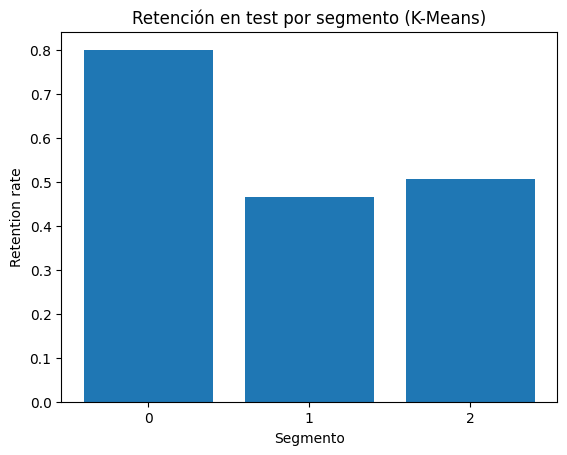

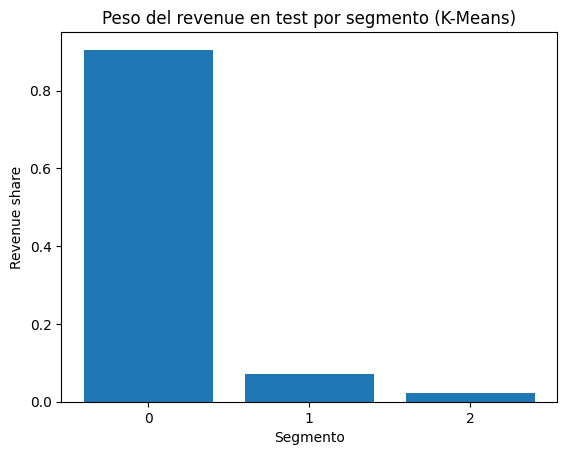

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(kpi_summary2.index.astype(str), kpi_summary2["retention_rate"])
plt.title("Retención en test por segmento (K-Means)")
plt.xlabel("Segmento"); plt.ylabel("Retention rate")
plt.show()

plt.figure()
plt.bar(kpi_summary2.index.astype(str), kpi_summary2["revenue_share_test"])
plt.title("Peso del revenue en test por segmento (K-Means)")
plt.xlabel("Segmento"); plt.ylabel("Revenue share")
plt.show()


In [40]:
seg_names = {
    0: "Dormant / Low-Value",
    1: "Weekend Shoppers",
    2: "Core / Regular",
    3: "Champions / High-Value Loyal"
}

kpi_w = kpi_summary2.copy()
kpi_w.insert(0, "segment_name", kpi_w.index.map(seg_names))

# Formato % en columnas de tasas
pct_cols = ["retention_rate", "buy_30_rate", "buy_60_rate", "buy_90_rate", "revenue_share_test"]
for c in pct_cols:
    kpi_w[c] = (kpi_w[c] * 100).round(1)

# Redondeo de magnitudes
num_cols = ["avg_rev_active","median_rev_active","exp_rev_per_customer","total_test_revenue"]
for c in num_cols:
    kpi_w[c] = kpi_w[c].round(1)

kpi_w["avg_orders_active"] = kpi_w["avg_orders_active"].round(2)
kpi_w["exp_orders_per_customer"] = kpi_w["exp_orders_per_customer"].round(2)

kpi_w


,segment_name,n_clients,retention_rate,avg_rev_active,median_rev_active,avg_orders_active,exp_rev_per_customer,exp_orders_per_customer,buy_30_rate,buy_60_rate,buy_90_rate,total_test_revenue,revenue_share_test
cluster_kmeans,,,,,,,,,,,,,
0,Dormant / Low-Value,2251,80.1,3585.0,1417.6,6.72,2871.5,5.38,29.9,40.6,48.7,6463673.8,90.5
1,Weekend Shoppers,1905,46.7,578.6,363.3,2.37,270.0,1.10,8.6,12.4,17.0,514336.0,7.2
2,Core / Regular,158,50.6,2061.5,567.4,3.28,1043.8,1.66,10.8,17.7,23.4,164919.7,2.3


In [41]:
kpi_w.to_excel(f"{OUT_DIR}/kpi_summary2_named.xlsx", index=True)


In [42]:
df_customers_train.columns


Index(['customer_id', 'frequency', 'monetary', 'avg_order_value',
       'avg_items_per_invoice', 'avg_lines_per_invoice', 'last_purchase',
       'first_purchase', 'weekend_ratio', 'recency_days', 'variety_u',
       'avg_days_between_purchases', 'return_ratio_lines',
       'return_ratio_revenue', 'period', 'cluster_kmeans', 'cluster_gmm',
       'cluster_dbscan'],
      dtype='object')

In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Recalcular matriz de transición (train -> test) si no existe ---
if "trans_mat" not in globals():
    overlap_ids = np.intersect1d(
        df_customers_train["customer_id"].values,
        df_customers_test["customer_id"].values
    )

    trans_df = (
        df_customers_train[df_customers_train["customer_id"].isin(overlap_ids)][["customer_id", "cluster_kmeans"]]
        .rename(columns={"cluster_kmeans": "cluster_train"})
        .merge(
            df_customers_test[df_customers_test["customer_id"].isin(overlap_ids)][["customer_id", "cluster_kmeans"]]
            .rename(columns={"cluster_kmeans": "cluster_test"}),
            on="customer_id",
            how="inner"
        )
    )

    trans_mat = pd.crosstab(
        trans_df["cluster_train"],
        trans_df["cluster_test"],
        normalize="index"
    ).sort_index().sort_index(axis=1)

    stay_rate = (trans_df["cluster_train"] == trans_df["cluster_test"]).mean()

    print("trans_mat recalculada. stay_rate =", round(float(stay_rate), 4), "| n_overlap =", len(trans_df))

# ============ Helpers ============
def save_df(df, name, out_dir, index=True):
    df.to_csv(f"{out_dir}/{name}.csv", index=index)
    df.to_excel(f"{out_dir}/{name}.xlsx", index=index)

def save_fig(fig, name, out_dir):
    fig.savefig(f"{out_dir}/{name}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

# ============ 1) Tablas clave ============
seg_names = {
    0: "Dormant / Low-Value",
    1: "Weekend Shoppers",
    2: "Core / Regular",
    3: "Champions / High-Value Loyal",
}

# Tabla resumen “para memoria”
seg_summary = pd.DataFrame({
    "segment_name": pd.Series(seg_names),
    "n_train": df_customers_train["cluster_kmeans"].value_counts().sort_index(),
    "share_train_%": (df_customers_train["cluster_kmeans"].value_counts(normalize=True).sort_index()*100).round(1),
    "median_recency_days": profile_train["recency_days"],
    "median_frequency": profile_train["frequency"],
    "median_monetary": profile_train["monetary"].round(2),
    "median_variety_u": profile_train["variety_u"],
    "mean_weekend_ratio": df_customers_train.groupby("cluster_kmeans")["weekend_ratio"].mean().sort_index().round(3),
    "retention_%": (kpi_summary2["retention_rate"]*100).round(1),
    "exp_rev_per_customer": kpi_summary2["exp_rev_per_customer"].round(1),
    "revenue_share_test_%": (kpi_summary2["revenue_share_test"]*100).round(1),
    "buy_30_%": (kpi_summary2["buy_30_rate"]*100).round(1),
    "buy_60_%": (kpi_summary2["buy_60_rate"]*100).round(1),
    "buy_90_%": (kpi_summary2["buy_90_rate"]*100).round(1),
})
seg_summary.index.name = "cluster"

# Dataset summary
dataset_summary = pd.DataFrame([{
    "n_lines_df_clean": len(df_clean),
    "date_min": df_clean["invoice_date"].min(),
    "date_max": df_clean["invoice_date"].max(),
    "pct_customer_id_null": float(df_clean["customer_id"].isna().mean()),
    "pct_returns_lines": float(df_clean["is_return"].mean()),
    "n_unique_customers_identified": int(df_clean["customer_id"].dropna().nunique()),
    "period_2009_2010_lines": int((df_clean["period"]=="2009-2010").sum()),
    "period_2010_2011_lines": int((df_clean["period"]=="2010-2011").sum()),
}])

# Caps p99
caps_tbl = pd.DataFrame({"cap_p99": caps}).T

# Exportar
save_df(dataset_summary, "dataset_summary", OUT_DIR, index=False)
save_df(caps_tbl, "caps_p99", OUT_DIR)
save_df(df_k, "kmeans_k_metrics_train", OUT_DIR, index=False)
save_df(profile_train, "kmeans_profile_train_median", OUT_DIR)
save_df(profile_test, "kmeans_profile_test_median", OUT_DIR)
save_df(share_tbl, "kmeans_cluster_shares_train_test", OUT_DIR)
save_df(trans_mat, "kmeans_transition_matrix", OUT_DIR)
save_df(seg_summary, "segment_summary_for_report", OUT_DIR)

# ============ 2) Figuras clave ============
# Elbow
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df_k["k"], df_k["inertia"], marker="o")
ax.set_title("K-Means — Elbow (Inertia) en train")
ax.set_xlabel("k")
ax.set_ylabel("Inertia")
save_fig(fig, "fig_kmeans_elbow_inertia", OUT_DIR)

# Silhouette
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df_k["k"], df_k["silhouette"], marker="o")
ax.set_title("K-Means — Silhouette en train (más alto = mejor)")
ax.set_xlabel("k")
ax.set_ylabel("Silhouette")
save_fig(fig, "fig_kmeans_silhouette", OUT_DIR)

# Davies-Bouldin
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df_k["k"], df_k["davies_bouldin"], marker="o")
ax.set_title("K-Means — Davies-Bouldin en train (más bajo = mejor)")
ax.set_xlabel("k")
ax.set_ylabel("Davies-Bouldin")
save_fig(fig, "fig_kmeans_davies_bouldin", OUT_DIR)

# Retención por segmento
fig, ax = plt.subplots(figsize=(6,4))
vals = (kpi_summary2["retention_rate"]*100).values
ax.bar(kpi_summary2.index.astype(str), vals)
ax.set_title("Retención en test por segmento (K-Means)")
ax.set_xlabel("Segmento")
ax.set_ylabel("Retención (%)")
save_fig(fig, "fig_retention_by_segment", OUT_DIR)

# Revenue share por segmento
fig, ax = plt.subplots(figsize=(6,4))
vals = (kpi_summary2["revenue_share_test"]*100).values
ax.bar(kpi_summary2.index.astype(str), vals)
ax.set_title("Peso del revenue en test por segmento (K-Means)")
ax.set_xlabel("Segmento")
ax.set_ylabel("Revenue share (%)")
save_fig(fig, "fig_revenue_share_by_segment", OUT_DIR)

# Matriz de transición (heatmap simple)
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(trans_mat.values, aspect="auto")
ax.set_title(f"Matriz de transición train→test (stay rate={stay_rate:.3f})")
ax.set_xlabel("Cluster en test")
ax.set_ylabel("Cluster en train")
ax.set_xticks(range(trans_mat.shape[1]))
ax.set_yticks(range(trans_mat.shape[0]))
ax.set_xticklabels(trans_mat.columns.astype(str))
ax.set_yticklabels(trans_mat.index.astype(str))
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
save_fig(fig, "fig_transition_matrix_heatmap", OUT_DIR)

print("Export finalizado en:", OUT_DIR)



trans_mat recalculada. stay_rate = 0.7161 | n_overlap = 2772
Export finalizado en: /content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058


In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) Checks + helpers
# =========================
assert "OUT_DIR" in globals(), "No existe OUT_DIR. Ejecuta antes tu celda donde lo defines."
os.makedirs(OUT_DIR, exist_ok=True)

def _save_df(df, name):
    df.to_csv(f"{OUT_DIR}/{name}.csv", index=False)
    df.to_excel(f"{OUT_DIR}/{name}.xlsx", index=False)

def _save_fig(fig, name):
    fig.savefig(f"{OUT_DIR}/{name}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

# Si ya tienes seg_names definido, lo usa; si no, crea nombres genéricos.
if "seg_names" not in globals():
    seg_names = {0:"Segment 0", 1:"Segment 1", 2:"Segment 2", 3:"Segment 3"}

# Lista de features: usa la tuya si existe; si no, infiere una razonable.
if "features" not in globals():
    candidate = [
        "recency_days","frequency","monetary","variety_u","avg_order_value",
        "avg_items_per_invoice","avg_lines_per_invoice","return_ratio_lines",
        "avg_days_between_purchases","weekend_ratio"
    ]
    features = [c for c in candidate if c in df_customers_train.columns]

# =========================
# A) Tabla train vs test con deltas
# =========================
# Si ya tienes profile_train/profile_test, los usa; si no, los calcula.
if "profile_train" in globals() and "profile_test" in globals():
    pt = profile_train.copy()
    ps = profile_test.copy()
else:
    pt = df_customers_train.groupby("cluster_kmeans")[features].median()
    ps = df_customers_test.groupby("cluster_kmeans")[features].median()

# Asegura mismo orden de clusters/columnas
pt = pt.sort_index()
ps = ps.reindex(pt.index).sort_index()

compare = pd.DataFrame({"cluster": pt.index})
compare["segment_name"] = compare["cluster"].map(seg_names)

for c in features:
    compare[f"train_median_{c}"] = pt[c].values
    compare[f"test_median_{c}"]  = ps[c].values
    compare[f"delta_{c}"]        = (ps[c] - pt[c]).values

_save_df(compare, "table_profile_train_vs_test_deltas")

# =========================
# B) PCA 2D train + test (scatter)
# =========================
from sklearn.decomposition import PCA

assert "X_train_scaled" in globals() and "X_test_scaled" in globals(), \
    "No existen X_train_scaled / X_test_scaled. Ejecuta antes tu preprocesado."

pca = PCA(n_components=2, random_state=42)
Z_train = pca.fit_transform(X_train_scaled)
Z_test  = pca.transform(X_test_scaled)

# TRAIN
fig, ax = plt.subplots(figsize=(6,5))
sc = ax.scatter(Z_train[:,0], Z_train[:,1], c=df_customers_train["cluster_kmeans"], s=8)
ax.set_title("PCA (2D) — Train (color por cluster K-Means)")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
plt.colorbar(sc, ax=ax)
_save_fig(fig, "fig_pca_train_clusters")

# TEST
fig, ax = plt.subplots(figsize=(6,5))
sc = ax.scatter(Z_test[:,0], Z_test[:,1], c=df_customers_test["cluster_kmeans"], s=8)
ax.set_title("PCA (2D) — Test (color por cluster K-Means)")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
plt.colorbar(sc, ax=ax)
_save_fig(fig, "fig_pca_test_clusters")

# =========================
# C) Boxplots R/F/M (train)
# =========================
def _boxplot_by_cluster(df, col):
    fig, ax = plt.subplots(figsize=(7,4))
    df.boxplot(column=col, by="cluster_kmeans", ax=ax)
    ax.set_title(f"Distribución de {col} por cluster (train)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(col)
    plt.suptitle("")
    _save_fig(fig, f"fig_box_{col}_by_cluster_train")

for col in ["recency_days", "frequency", "monetary"]:
    if col in df_customers_train.columns:
        _boxplot_by_cluster(df_customers_train, col)

# =========================
# D) Pareto / concentración revenue en TEST
# =========================
# Usará df_test_lines si existe; si no, deriva del df_clean por periodo.
if "df_test_lines" in globals():
    test_lines = df_test_lines.copy()
else:
    assert "df_clean" in globals(), "No existe df_test_lines ni df_clean."
    test_lines = df_clean[df_clean["period"]=="2010-2011"].copy()

# Solo compras (excluye devoluciones) y clientes identificados
test_lines = test_lines[test_lines["customer_id"].notna()].copy()
if "is_return" in test_lines.columns:
    test_lines = test_lines[~test_lines["is_return"]].copy()

assert "revenue" in test_lines.columns, "No existe columna revenue en las líneas de test."

rev_per_cust = test_lines.groupby("customer_id")["revenue"].sum().sort_values(ascending=False)
rev_per_cust = rev_per_cust[rev_per_cust > 0]  # por seguridad

cum_share = (rev_per_cust.cumsum() / rev_per_cust.sum()).values
x = (np.arange(1, len(cum_share)+1) / len(cum_share))

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(x, cum_share)
ax.set_title("Curva de concentración (Pareto) — Revenue en test")
ax.set_xlabel("% clientes (ordenados por revenue desc.)")
ax.set_ylabel("% revenue acumulado")
_save_fig(fig, "fig_pareto_revenue_test")

# =========================
# F) Heatmap de perfil de clusters (medianas normalizadas)
# =========================
med = df_customers_train.groupby("cluster_kmeans")[features].median().sort_index()
# z-score por columna para comparar “forma” de perfiles
med_z = (med - med.mean(axis=0)) / (med.std(axis=0).replace(0, np.nan))

fig, ax = plt.subplots(figsize=(10,4))
im = ax.imshow(med_z.values, aspect="auto")
ax.set_title("Perfil de clusters (medianas normalizadas z-score) — Train")
ax.set_xlabel("Features")
ax.set_ylabel("Cluster")
ax.set_xticks(range(len(features)))
ax.set_xticklabels(features, rotation=45, ha="right")
ax.set_yticks(range(med_z.shape[0]))
ax.set_yticklabels(med_z.index.astype(str))
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
_save_fig(fig, "fig_cluster_profile_heatmap_train")

print("OK — Pack A+B+C+D+F generado y guardado en:", OUT_DIR)


OK — Pack A+B+C+D+F generado y guardado en: /content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058


In [45]:
!ls -lah /content/drive | head -n 20
!ls -lah /content/drive/MyDrive | head -n 20


total 12K
drwxr-xr-x 3 root root 4.0K Jan 10 10:58 .
drwxr-xr-x 1 root root 4.0K Jan 10 10:58 ..
drwxr-xr-x 3 root root 4.0K Jan 10 10:58 MyDrive
total 12K
drwxr-xr-x 3 root root 4.0K Jan 10 10:58 .
drwxr-xr-x 3 root root 4.0K Jan 10 10:58 ..
drwxr-xr-x 3 root root 4.0K Jan 10 10:58 TFG_Segmentacion


In [46]:
import os
os.makedirs(OUT_DIR, exist_ok=True)
print("Creada? ", os.path.exists(OUT_DIR), "| OUT_DIR =", OUT_DIR)


Creada?  True | OUT_DIR = /content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058


In [47]:
os.makedirs(OUT_DIR, exist_ok=True)


In [48]:
import glob
files = sorted(glob.glob(OUT_DIR + "/*"))
print("Nº archivos:", len(files))
print("\n".join(files[:50]))


Nº archivos: 49
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058/caps_p99.csv
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058/caps_p99.xlsx
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058/cluster_shares_train_test.csv
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058/dataset_summary.csv
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058/dataset_summary.xlsx
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058/dbscan_grid_train.csv
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058/df_customers_test_with_all_labels.csv
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058/df_customers_test_with_clusters.csv
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058/df_customers_test_with_kmeans_gmm.csv
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058/df_customers_train_with_all_labels.csv
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260110_1058/df_customers_train_with_cluster

In [49]:
import os

# crea un archivo de prueba
with open(f"{OUT_DIR}/_TEST_OK.txt", "w") as f:
    f.write("Drive OK")

!ls -lah "{OUT_DIR}"


total 5.3M
drwxr-xr-x 2 root root 4.0K Jan 10 10:59 .
drwxr-xr-x 3 root root 4.0K Jan 10 10:58 ..
-rw-r--r-- 1 root root  732 Jan 10 10:58 caps_p99.csv
-rw-r--r-- 1 root root 5.2K Jan 10 10:58 caps_p99.xlsx
-rw-r--r-- 1 root root  233 Jan 10 10:58 cluster_shares_train_test.csv
-rw-r--r-- 1 root root  258 Jan 10 10:58 dataset_summary.csv
-rw-r--r-- 1 root root 5.1K Jan 10 10:58 dataset_summary.xlsx
-rw-r--r-- 1 root root 1.9K Jan 10 10:58 dbscan_grid_train.csv
-rw-r--r-- 1 root root 576K Jan 10 10:58 df_customers_test_with_all_labels.csv
-rw-r--r-- 1 root root 568K Jan 10 10:58 df_customers_test_with_clusters.csv
-rw-r--r-- 1 root root 576K Jan 10 10:58 df_customers_test_with_kmeans_gmm.csv
-rw-r--r-- 1 root root 591K Jan 10 10:58 df_customers_train_with_all_labels.csv
-rw-r--r-- 1 root root 573K Jan 10 10:58 df_customers_train_with_clusters.csv
-rw-r--r-- 1 root root 582K Jan 10 10:58 df_customers_train_with_kmeans_gmm.csv
-rw-r--r-- 1 root root  84K Jan 10 10:59 fig_box_frequency_by_c

In [50]:
import os, shutil
if os.path.exists("/content/drive"):
    shutil.rmtree("/content/drive", ignore_errors=True)

from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [51]:
import os, glob
import pandas as pd

# 1) Asegura OUT_DIR
OUT_DIR = "/content/drive/MyDrive/TFG_Segmentacion/outputs/20260107_1230"
os.makedirs(OUT_DIR, exist_ok=True)
print("OUT_DIR =", OUT_DIR)
print("Existe OUT_DIR?", os.path.exists(OUT_DIR))

# 2) Helpers
def save_df(df, name):
    path = os.path.join(OUT_DIR, f"{name}.csv")
    df.to_csv(path, index=True)
    print("Guardado:", path)

def save_fig(fig, name):
    path = os.path.join(OUT_DIR, f"{name}.png")
    fig.savefig(path, dpi=200, bbox_inches="tight")
    print("Guardado:", path)

# 3) Guarda tablas clave (asegúrate de que estas variables existen)
# Ejemplos típicos en tu caso:
# - kpi_summary2 (tabla KPIs por segmento)
# - trans_mat (matriz transición train->test)
# - df_db (grid DBSCAN)
# - métricas kmeans/gmm (si las tienes en df)

save_df(kpi_summary2, "kmeans_kpi_summary2")
save_df(trans_mat, "kmeans_transition_matrix")   # IMPORTANTE: que se llame trans_mat en tu notebook
save_df(df_db, "dbscan_grid_results")            # si existe

# 4) Si quieres un Excel único “para Word”
xlsx_path = os.path.join(OUT_DIR, "TABLAS_PARA_MEMORIA.xlsx")
with pd.ExcelWriter(xlsx_path, engine="openpyxl") as writer:
    kpi_summary2.to_excel(writer, sheet_name="KPIs_KMeans")
    trans_mat.to_excel(writer, sheet_name="Transicion_train_test")
    if "df_db" in globals():
        df_db.to_excel(writer, sheet_name="DBSCAN_grid", index=False)
print("Guardado:", xlsx_path)

# 5) Verifica qué se ha escrito
files = sorted(glob.glob(OUT_DIR + "/*"))
print("Nº archivos en OUT_DIR:", len(files))
print("\n".join(files))


OUT_DIR = /content/drive/MyDrive/TFG_Segmentacion/outputs/20260107_1230
Existe OUT_DIR? True
Guardado: /content/drive/MyDrive/TFG_Segmentacion/outputs/20260107_1230/kmeans_kpi_summary2.csv
Guardado: /content/drive/MyDrive/TFG_Segmentacion/outputs/20260107_1230/kmeans_transition_matrix.csv
Guardado: /content/drive/MyDrive/TFG_Segmentacion/outputs/20260107_1230/dbscan_grid_results.csv
Guardado: /content/drive/MyDrive/TFG_Segmentacion/outputs/20260107_1230/TABLAS_PARA_MEMORIA.xlsx
Nº archivos en OUT_DIR: 4
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260107_1230/TABLAS_PARA_MEMORIA.xlsx
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260107_1230/dbscan_grid_results.csv
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260107_1230/kmeans_kpi_summary2.csv
/content/drive/MyDrive/TFG_Segmentacion/outputs/20260107_1230/kmeans_transition_matrix.csv


In [52]:
# 0) Montar Drive (sin force_remount salvo que lo necesites)
from google.colab import drive
drive.mount('/content/drive')

import os, glob

# 1) Definir OUT_DIR y crearlo (siempre)
OUT_DIR = "/content/drive/MyDrive/TFG_Segmentation/outputs/20260107_1230"
os.makedirs(OUT_DIR, exist_ok=True)

# 2) Verificar que existe
print("OUT_DIR:", OUT_DIR, "| existe:", os.path.exists(OUT_DIR))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OUT_DIR: /content/drive/MyDrive/TFG_Segmentation/outputs/20260107_1230 | existe: True


In [53]:
import pandas as pd
import numpy as np

# Base solo compras, con cliente identificado
d = df_clean.copy()
d["invoice_date"] = pd.to_datetime(d["invoice_date"], errors="coerce")

d_p = d[(d["customer_id"].notna()) & (~d["is_return"])].copy()
d_p["customer_id"] = d_p["customer_id"].astype(int)

# Detectar nombre de columna invoice
invoice_col = "invoice" if "invoice" in d_p.columns else "invoice_no"

# Dataset a nivel factura (tu "Sales" equivalente = invoice_revenue)
inv_sales = (
    d_p.groupby([invoice_col], as_index=False)
      .agg(
          invoice_date=("invoice_date","max"),
          invoice_revenue=("revenue","sum"),
          invoice_qty=("quantity","sum"),
          n_lines=("revenue","size"),
          n_customers=("customer_id","nunique"),
      )
)

inv_sales["month"] = inv_sales["invoice_date"].dt.to_period("M").astype(str)
inv_sales["day"]   = inv_sales["invoice_date"].dt.date

inv_sales.head()


,invoice,invoice_date,invoice_revenue,invoice_qty,n_lines,n_customers,month,day
0,489434,2009-12-01 07:45:00,505.30,166,8,1,2009-12,2009-12-01
1,489435,2009-12-01 07:46:00,145.80,60,4,1,2009-12,2009-12-01
2,489436,2009-12-01 09:06:00,630.33,193,19,1,2009-12,2009-12-01
3,489437,2009-12-01 09:08:00,310.75,145,23,1,2009-12,2009-12-01
4,489438,2009-12-01 09:24:00,2286.24,826,17,1,2009-12,2009-12-01


In [54]:
def table_variables(df, name="df"):
    out = pd.DataFrame({
        "dataset": name,
        "variable": df.columns,
        "dtype": [str(t) for t in df.dtypes.values],
        "missing_%": (df.isna().mean().values * 100).round(2),
        "example": [df[c].dropna().iloc[0] if df[c].notna().any() else np.nan for c in df.columns]
    })
    return out

tab_vars_clean = table_variables(df_clean, "df_clean")
tab_vars_customers = table_variables(df_customers, "df_customers")
tab_vars_invoices = table_variables(df_invoices, "df_invoices")
tab_vars_seg = table_variables(df_segmentation, "df_segmentation")

tabla_1_vars = pd.concat([tab_vars_clean, tab_vars_customers, tab_vars_invoices, tab_vars_seg], ignore_index=True)
tabla_1_vars.head(20)


,dataset,variable,dtype,missing_%,example
0,df_clean,invoice,object,0.00,489434
1,df_clean,stock_code,object,0.00,85048
2,df_clean,description,object,0.42,15CM CHRISTMAS GLASS BALL 20 LIGHTS
3,df_clean,quantity,int64,0.00,12
4,df_clean,invoice_date,datetime64[ns],0.00,2009-12-01 07:45:00
5,df_clean,price,float64,0.00,6.95
6,df_clean,customer_id,float64,23.02,13085.0
7,df_clean,country,object,0.00,United Kingdom
8,df_clean,period,object,0.00,2009-2010
9,df_clean,revenue,float64,0.00,83.4


In [55]:
print("Rango temporal df_clean:", df_clean["invoice_date"].min(), "->", df_clean["invoice_date"].max())
print("\nPeriodos (df_clean):")
print(df_clean["period"].value_counts(dropna=False))

# Tabla resumen por periodo
cov = (df_clean.assign(invoice_date=pd.to_datetime(df_clean["invoice_date"], errors="coerce"))
              .groupby("period")
              .agg(
                  n_lines=("period","size"),
                  n_customers=("customer_id", lambda s: s.dropna().nunique()),
                  min_date=("invoice_date","min"),
                  max_date=("invoice_date","max")
              )
              .reset_index()
)
cov


Rango temporal df_clean: 2009-12-01 07:45:00 -> 2011-12-09 12:50:00

Periodos (df_clean):
period
2010-2011    536642
2009-2010    518596
Name: count, dtype: int64


,period,n_lines,n_customers,min_date,max_date
0,2009-2010,518596,4383,2009-12-01 07:45:00,2010-12-09 20:01:00
1,2010-2011,536642,4372,2010-12-01 08:26:00,2011-12-09 12:50:00


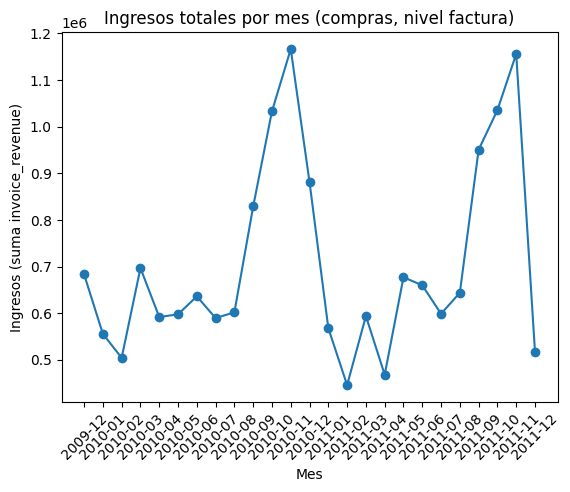

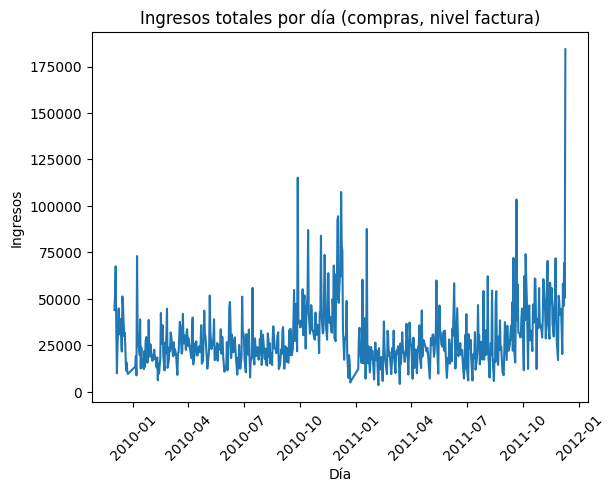

In [56]:
import matplotlib.pyplot as plt

# Por mes
m = inv_sales.groupby("month", as_index=False)["invoice_revenue"].sum().sort_values("month")

plt.figure()
plt.plot(m["month"], m["invoice_revenue"], marker="o")
plt.title("Ingresos totales por mes (compras, nivel factura)")
plt.xlabel("Mes")
plt.ylabel("Ingresos (suma invoice_revenue)")
plt.xticks(rotation=45)
plt.show()

# Por día (ojo: puede ser largo; puedes limitar a top N días o usar rolling)
dly = inv_sales.groupby("day", as_index=False)["invoice_revenue"].sum().sort_values("day")

plt.figure()
plt.plot(dly["day"], dly["invoice_revenue"])
plt.title("Ingresos totales por día (compras, nivel factura)")
plt.xlabel("Día")
plt.ylabel("Ingresos")
plt.xticks(rotation=45)
plt.show()


In [57]:
s = inv_sales["invoice_revenue"].dropna()

tabla_2_desc = pd.DataFrame({
    "media": [s.mean()],
    "mediana": [s.median()],
    "moda": [s.mode().iloc[0] if not s.mode().empty else np.nan],
    "varianza": [s.var()],
    "desv_est": [s.std()],
    "min": [s.min()],
    "max": [s.max()],
    "rango": [s.max() - s.min()],
}).round(4)

tabla_2_desc


,media,mediana,moda,varianza,desv_est,min,max,rango
0,478.3086,304.64,15.0,1.889917e+06,1374.7426,0.0,168469.6,168469.6


In [58]:
tabla_3_forma = pd.DataFrame({
    "skewness": [s.skew()],
    "kurtosis": [s.kurtosis()],
    "p01": [s.quantile(0.01)],
    "p05": [s.quantile(0.05)],
    "p25": [s.quantile(0.25)],
    "p50": [s.quantile(0.50)],
    "p75": [s.quantile(0.75)],
    "p95": [s.quantile(0.95)],
    "p99": [s.quantile(0.99)],
}).round(4)

tabla_3_forma


,skewness,kurtosis,p01,p05,p25,p50,p75,p95,p99
0,59.635,6393.3669,8.4948,36.355,159.35,304.64,487.325,1249.112,3697.2512


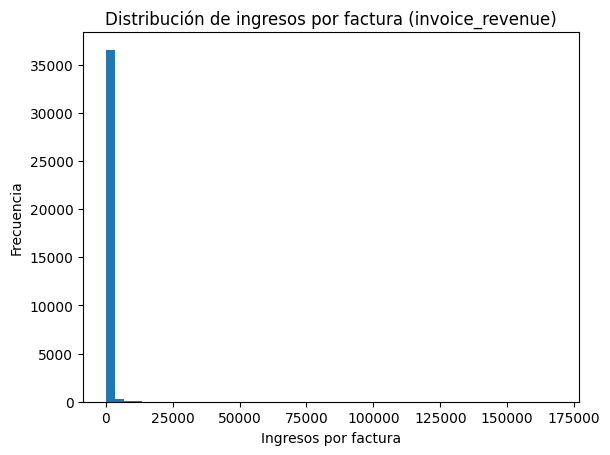

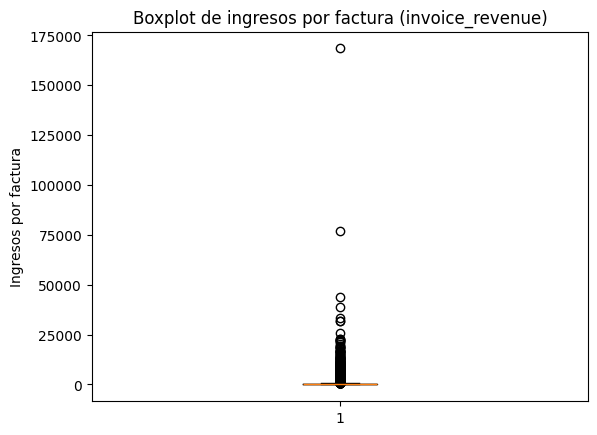

In [59]:
plt.figure()
plt.hist(s, bins=50)
plt.title("Distribución de ingresos por factura (invoice_revenue)")
plt.xlabel("Ingresos por factura")
plt.ylabel("Frecuencia")
plt.show()

plt.figure()
plt.boxplot(s, vert=True)
plt.title("Boxplot de ingresos por factura (invoice_revenue)")
plt.ylabel("Ingresos por factura")
plt.show()


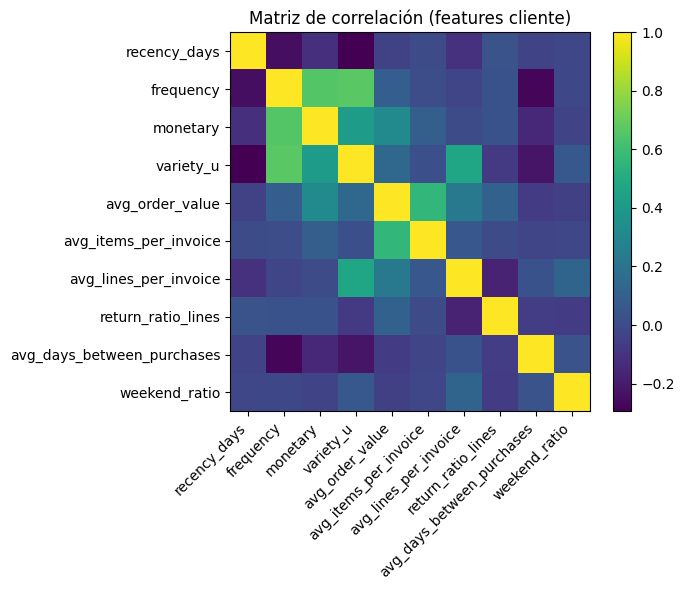

In [60]:
import numpy as np

feat_df = df_customers_train[features].copy()

corr = feat_df.corr(numeric_only=True)

plt.figure(figsize=(7,6))
plt.imshow(corr.values, aspect="auto")
plt.title("Matriz de correlación (features cliente)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.tight_layout()
plt.show()


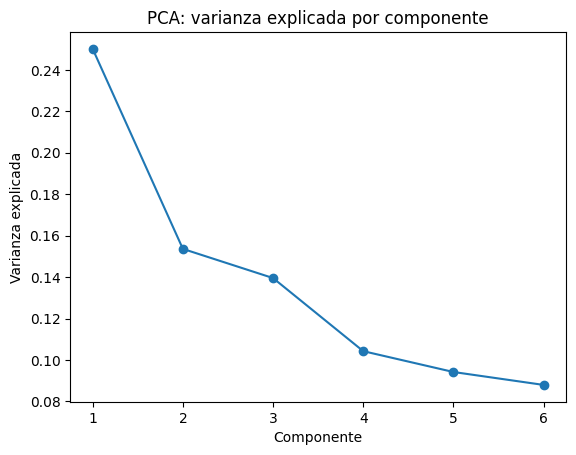

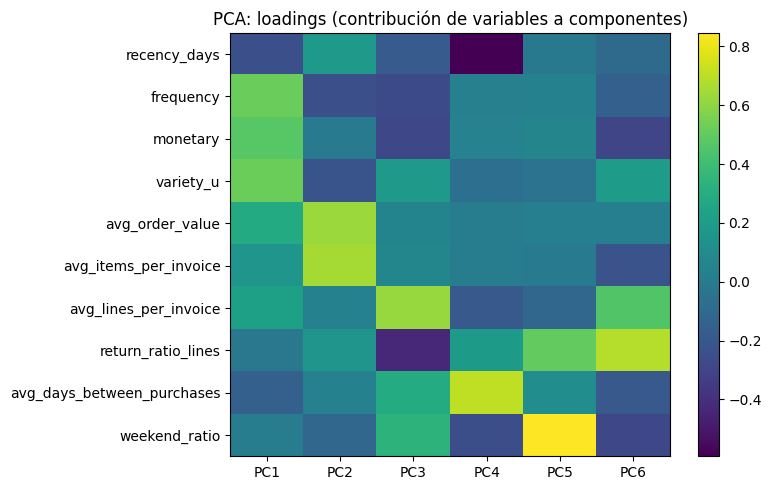

,PC1,PC2,PC3,PC4,PC5,PC6
recency_days,-0.242043,0.185697,-0.180601,-0.593027,-0.009343,-0.093563
frequency,0.514530,-0.239125,-0.272569,0.033792,0.038393,-0.153192
monetary,0.471990,0.002798,-0.282261,0.045492,0.061651,-0.290157
variety_u,0.523326,-0.217990,0.179356,-0.066924,-0.042989,0.197456
avg_order_value,0.284076,0.627871,0.058322,0.019096,0.030464,0.026434
avg_items_per_invoice,0.158262,0.651186,0.068038,0.018475,0.004828,-0.223846
avg_lines_per_invoice,0.226696,0.039754,0.623724,-0.188459,-0.116467,0.454331
return_ratio_lines,-0.014692,0.159680,-0.428247,0.193018,0.500329,0.686552
avg_days_between_purchases,-0.149856,0.037258,0.294556,0.710355,0.112346,-0.193285
weekend_ratio,0.014843,-0.118647,0.337681,-0.250090,0.845768,-0.280470


In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_customers_train[features].copy()
X = X.fillna(X.median(numeric_only=True))

sc = StandardScaler()
Xz = sc.fit_transform(X)

pca = PCA(n_components=min(len(features), 6), random_state=42)
Z = pca.fit_transform(Xz)

# Varianza explicada
plt.figure()
plt.plot(range(1, pca.n_components_+1), pca.explained_variance_ratio_, marker="o")
plt.title("PCA: varianza explicada por componente")
plt.xlabel("Componente")
plt.ylabel("Varianza explicada")
plt.show()

# Heatmap de loadings (lo que tú puedes titular como “correlación con PCA”)
loadings = pd.DataFrame(pca.components_.T, index=features,
                        columns=[f"PC{i}" for i in range(1, pca.n_components_+1)])

plt.figure(figsize=(8,5))
plt.imshow(loadings.values, aspect="auto")
plt.title("PCA: loadings (contribución de variables a componentes)")
plt.xticks(range(loadings.shape[1]), loadings.columns)
plt.yticks(range(loadings.shape[0]), loadings.index)
plt.colorbar()
plt.tight_layout()
plt.show()

loadings


In [62]:
def outlier_iqr_summary(df_num):
    rows = []
    for col in df_num.columns:
        x = df_num[col].dropna()
        q1, q3 = x.quantile(0.25), x.quantile(0.75)
        iqr = q3 - q1
        lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
        n_out = ((x < lo) | (x > hi)).sum()
        rows.append({
            "variable": col,
            "n_outliers": int(n_out),
            "outliers_%": round(100*n_out/len(x), 2) if len(x)>0 else np.nan,
            "min": x.min(),
            "max": x.max()
        })
    return pd.DataFrame(rows).sort_values("outliers_%", ascending=False)

tabla_4_outliers = outlier_iqr_summary(df_customers_train[features])
tabla_4_outliers


,variable,n_outliers,outliers_%,min,max
9,weekend_ratio,627,14.53,0.0,1.000000
7,return_ratio_lines,548,12.70,0.0,0.755102
2,monetary,425,9.85,0.0,349164.350000
3,variety_u,320,7.42,1.0,1741.000000
4,avg_order_value,299,6.93,0.0,11880.840000
5,avg_items_per_invoice,291,6.75,1.0,87167.000000
1,frequency,285,6.61,1.0,205.000000
8,avg_days_between_purchases,172,5.95,0.0,361.000000
6,avg_lines_per_invoice,231,5.35,1.0,236.000000
0,recency_days,177,4.10,0.0,373.000000


In [63]:
(df_customers["revenue_total"] < 0).sum(), df_customers.shape[0]


(np.int64(85), 5942)

In [64]:
import pandas as pd

def binary_columns(df: pd.DataFrame, max_unique: int = 2):
    """
    Devuelve columnas binarias (exactamente 2 valores distintos) incluyendo NaN.
    Además muestra los valores y conteos para revisar si son 0/1, True/False, etc.
    """
    bin_cols = []
    details = []

    for col in df.columns:
        s = df[col]
        nun = s.nunique(dropna=True)
        if nun == max_unique:  # típicamente 2
            vals = list(pd.unique(s.dropna()))
            bin_cols.append(col)

            vc = s.value_counts(dropna=False)
            # resumimos hasta 10 filas de conteos
            top_counts = ", ".join([f"{idx}: {cnt}" for idx, cnt in vc.head(10).items()])
            details.append({
                "column": col,
                "dtype": str(s.dtype),
                "unique_non_null": nun,
                "values_non_null": vals,
                "counts_sample": top_counts
            })

    return bin_cols, pd.DataFrame(details)

# --- USO: elige el dataframe que quieras analizar ---
bin_df_clean, bin_details_clean = binary_columns(df_clean)
bin_df_invoices, bin_details_invoices = binary_columns(df_invoices)
bin_df_customers, bin_details_customers = binary_columns(df_customers)
bin_df_segmentation, bin_details_segmentation = binary_columns(df_segmentation)

print("Binarias en df_clean:", bin_df_clean)
print("Binarias en df_invoices:", bin_df_invoices)
print("Binarias en df_customers:", bin_df_customers)
print("Binarias en df_segmentation:", bin_df_segmentation)

# Ver detalle (recomendado)
bin_details_clean


Binarias en df_clean: ['period', 'is_return']
Binarias en df_invoices: ['is_weekend']
Binarias en df_customers: []
Binarias en df_segmentation: ['period', 'is_return']


,column,dtype,unique_non_null,values_non_null,counts_sample
0,period,object,2,"[2009-2010, 2010-2011]","2010-2011: 536642, 2009-2010: 518596"
1,is_return,bool,2,"[False, True]","False: 1032348, True: 22890"


In [65]:
import pandas as pd

tabla_52 = pd.DataFrame([
    {
        "Nivel": "Línea (df_clean)",
        "Unidad de análisis": "Producto dentro de una factura",
        "Identificadores": "invoice, stock_code, customer_id",
        "Objetivo analítico": "Limpiar, derivar revenue y preparar agregaciones",
        "Ejemplos de variables": "quantity, price, invoice_date, revenue, is_return"
    },
    {
        "Nivel": "Factura (df_invoices)",
        "Unidad de análisis": "Factura / pedido",
        "Identificadores": "invoice",
        "Objetivo analítico": "Analizar valor del pedido y distribución de ingresos por factura",
        "Ejemplos de variables": "invoice_revenue, invoice_qty, n_lines, invoice_date"
    },
    {
        "Nivel": "Cliente (df_customers)",
        "Unidad de análisis": "Cliente",
        "Identificadores": "customer_id",
        "Objetivo analítico": "Construir variables de comportamiento para segmentación",
        "Ejemplos de variables": "recency_days, n_invoices, revenue_total, n_products"
    },
    {
        "Nivel": "Cliente (features para ML)",
        "Unidad de análisis": "Cliente (vector de variables)",
        "Identificadores": "customer_id",
        "Objetivo analítico": "Segmentación con ML (KMeans / GMM / DBSCAN)",
        "Ejemplos de variables": "frequency, monetary, variety_u, return_ratio_lines, weekend_ratio"
    }
])

tabla_52


,Nivel,Unidad de análisis,Identificadores,Objetivo analítico,Ejemplos de variables
0,Línea (df_clean),Producto dentro de una factura,"invoice, stock_code, customer_id","Limpiar, derivar revenue y preparar agregaciones","quantity, price, invoice_date, revenue, is_return"
1,Factura (df_invoices),Factura / pedido,invoice,Analizar valor del pedido y distribución de in...,"invoice_revenue, invoice_qty, n_lines, invoice..."
2,Cliente (df_customers),Cliente,customer_id,Construir variables de comportamiento para seg...,"recency_days, n_invoices, revenue_total, n_pro..."
3,Cliente (features para ML),Cliente (vector de variables),customer_id,Segmentación con ML (KMeans / GMM / DBSCAN),"frequency, monetary, variety_u, return_ratio_l..."


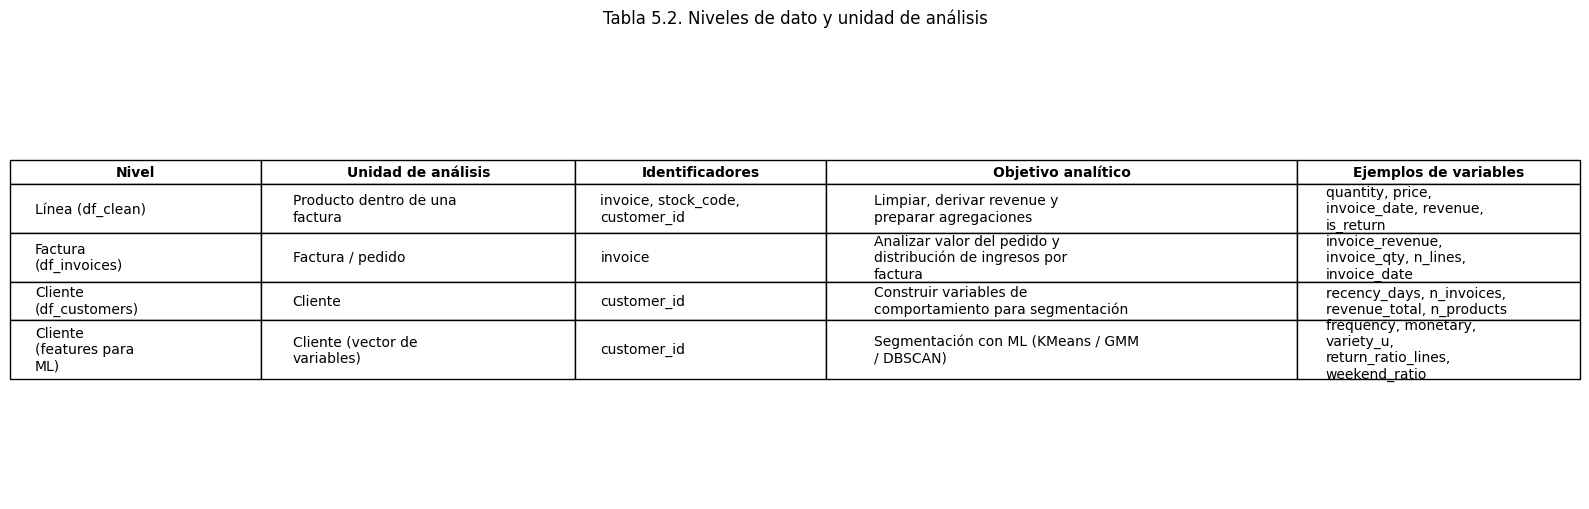

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# Si tabla_52 ya existe, úsala.
# tabla_52 = ...

def wrap_text(s, width):
    return "\n".join(textwrap.wrap(str(s), width=width))

tabla_plot = tabla_52.copy()

# Wrap por columna (ajusta anchos si quieres)
wrap_widths = {
    "Nivel": 16,
    "Unidad de análisis": 22,
    "Identificadores": 20,
    "Objetivo analítico": 34,
    "Ejemplos de variables": 28
}

for col, w in wrap_widths.items():
    tabla_plot[col] = tabla_plot[col].apply(lambda x: wrap_text(x, w))

# Figura más alta para que quepan las líneas
fig, ax = plt.subplots(figsize=(16, 5.2))
ax.axis("off")

col_widths = [0.16, 0.20, 0.16, 0.30, 0.18]

tbl = ax.table(
    cellText=tabla_plot.values,
    colLabels=tabla_plot.columns,
    cellLoc="left",
    colLoc="center",
    loc="center",
    colWidths=col_widths
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)

# Estilo cabecera y bordes
for (r, c), cell in tbl.get_celld().items():
    cell.set_linewidth(1.0)
    if r == 0:
        cell.set_text_props(weight="bold")
        cell.set_height(cell.get_height() * 1.25)

# --- Altura dinámica por fila (clave para que no se pise el texto) ---
n_rows = tabla_plot.shape[0]
n_cols = tabla_plot.shape[1]

# calcula para cada fila cuántas líneas máximas hay en alguna columna
max_lines_per_row = []
for i in range(n_rows):
    row_texts = [tabla_plot.iloc[i, j] for j in range(n_cols)]
    max_lines = max(str(t).count("\n") + 1 for t in row_texts)
    max_lines_per_row.append(max_lines)

# aplica altura proporcional
base_h = tbl[(1, 0)].get_height()  # altura base de una celda de datos
for i, max_lines in enumerate(max_lines_per_row, start=1):  # filas datos empiezan en 1
    for j in range(n_cols):
        tbl[(i, j)].set_height(base_h * (0.9 + 0.55 * max_lines))

plt.title("Tabla 5.2. Niveles de dato y unidad de análisis", pad=12)
plt.tight_layout()
plt.show()


In [67]:
import pandas as pd
import numpy as np

def build_dict(df, dataset_name):
    return pd.DataFrame({
        "dataset": dataset_name,
        "variable": df.columns,
        "dtype": [str(df[c].dtype) for c in df.columns],
        "missing_%": [round(df[c].isna().mean()*100, 2) for c in df.columns],
        "example": [df[c].dropna().iloc[0] if df[c].notna().any() else np.nan for c in df.columns]
    })

df_dict = pd.concat([
    build_dict(df_clean, "df_clean"),
    build_dict(df_customers, "df_customers"),
    build_dict(df_invoices, "df_invoices")
], ignore_index=True)

df_dict


,dataset,variable,dtype,missing_%,example
0,df_clean,invoice,object,0.00,489434
1,df_clean,stock_code,object,0.00,85048
2,df_clean,description,object,0.42,15CM CHRISTMAS GLASS BALL 20 LIGHTS
3,df_clean,quantity,int64,0.00,12
4,df_clean,invoice_date,datetime64[ns],0.00,2009-12-01 07:45:00
5,df_clean,price,float64,0.00,6.95
6,df_clean,customer_id,float64,23.02,13085.0
7,df_clean,country,object,0.00,United Kingdom
8,df_clean,period,object,0.00,2009-2010
9,df_clean,revenue,float64,0.00,83.4


In [68]:
df_invoices.head(5)


,customer_id,invoice,invoice_date,revenue_invoice,weekday,is_weekend
0,12346,491725,2009-12-14 08:34:00,45.0,0,False
1,12346,491742,2009-12-14 11:00:00,22.5,0,False
2,12346,491744,2009-12-14 11:02:00,22.5,0,False
3,12346,492718,2009-12-18 10:47:00,22.5,4,False
4,12346,492722,2009-12-18 10:55:00,1.0,4,False


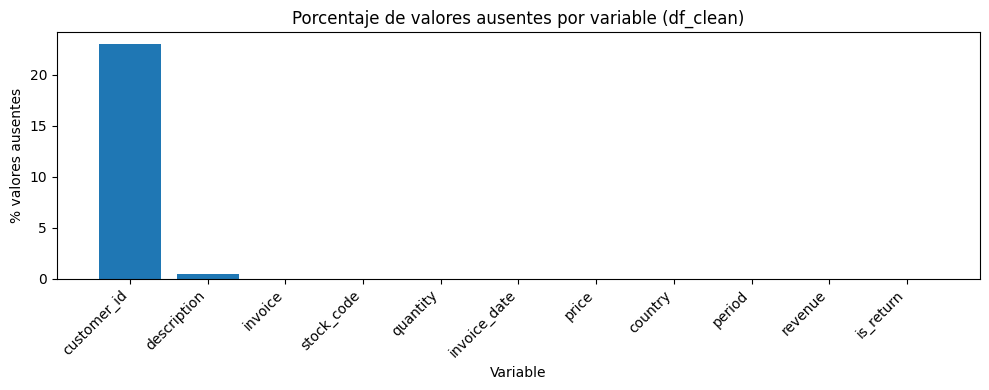

,0
customer_id,23.015661
description,0.415262
invoice,0.000000
stock_code,0.000000
quantity,0.000000
invoice_date,0.000000
price,0.000000
country,0.000000
period,0.000000
revenue,0.000000


In [69]:
import matplotlib.pyplot as plt

missing_pct = (df_clean.isna().mean() * 100).sort_values(ascending=False)

plt.figure(figsize=(10,4))
plt.bar(missing_pct.index.astype(str), missing_pct.values)
plt.title("Porcentaje de valores ausentes por variable (df_clean)")
plt.xlabel("Variable")
plt.ylabel("% valores ausentes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

missing_pct


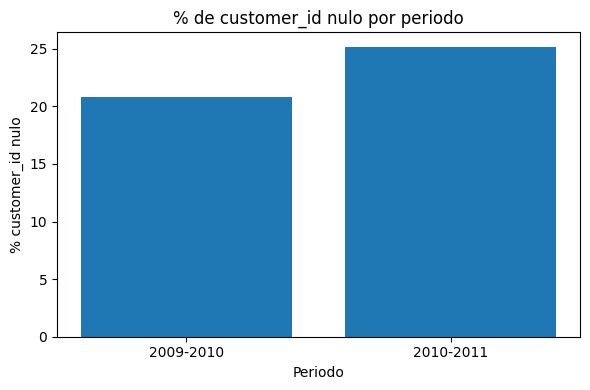

,customer_id
period,
2009-2010,20.793257
2010-2011,25.163330


In [70]:
missing_customer_by_period = (
    df_clean.groupby("period")["customer_id"]
    .apply(lambda s: s.isna().mean()*100)
    .sort_index()
)

plt.figure(figsize=(6,4))
plt.bar(missing_customer_by_period.index.astype(str), missing_customer_by_period.values)
plt.title("% de customer_id nulo por periodo")
plt.xlabel("Periodo")
plt.ylabel("% customer_id nulo")
plt.tight_layout()
plt.show()

missing_customer_by_period


In [71]:
import matplotlib.pyplot as plt
import pandas as pd

tmp = df_clean.copy()
tmp["has_customer"] = tmp["customer_id"].notna()

counts = (tmp.groupby(["period", "has_customer"])
            .size()
            .unstack(fill_value=0)
            .rename(columns={False: "Sin customer_id", True: "Con customer_id"}))

counts


has_customer,Sin customer_id,Con customer_id
period,,
2009-2010,107833,410763
2010-2011,135037,401605


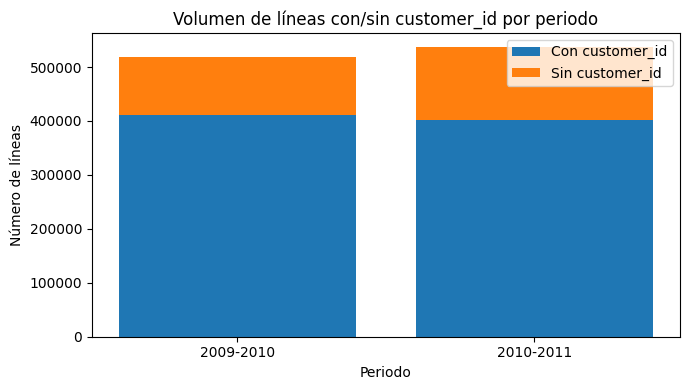

In [72]:
# Gráfico barras apiladas (volumen absoluto)
plt.figure(figsize=(7,4))
plt.bar(counts.index.astype(str), counts["Con customer_id"], label="Con customer_id")
plt.bar(counts.index.astype(str), counts["Sin customer_id"], bottom=counts["Con customer_id"], label="Sin customer_id")
plt.title("Volumen de líneas con/sin customer_id por periodo")
plt.xlabel("Periodo")
plt.ylabel("Número de líneas")
plt.legend()
plt.tight_layout()
plt.show()


In [73]:
df_clean["invoice_date"] = pd.to_datetime(df_clean["invoice_date"], errors="coerce")

res_period = (df_clean.groupby("period")
              .agg(
                  n_lines=("invoice", "size"),
                  n_customers=("customer_id", lambda s: s.nunique()),
                  min_date=("invoice_date","min"),
                  max_date=("invoice_date","max")
              )
              .reset_index())

res_period


,period,n_lines,n_customers,min_date,max_date
0,2009-2010,518596,4383,2009-12-01 07:45:00,2010-12-09 20:01:00
1,2010-2011,536642,4372,2010-12-01 08:26:00,2011-12-09 12:50:00


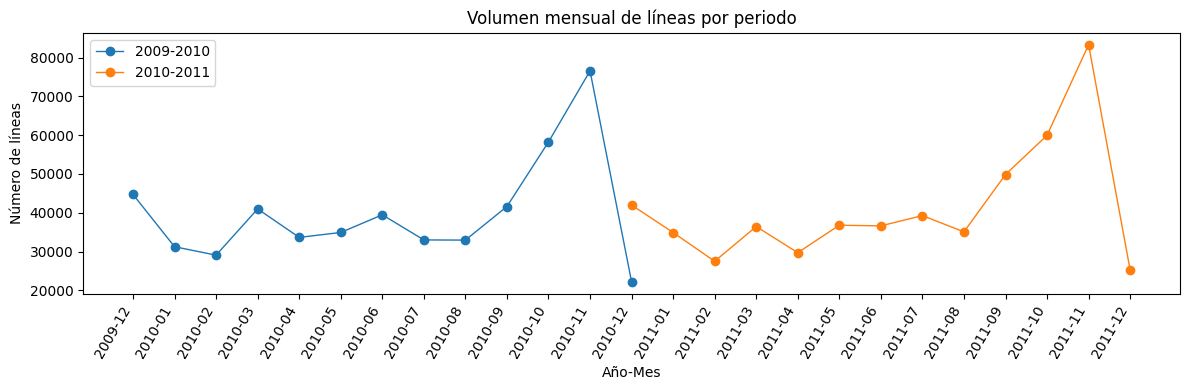

In [74]:
tmp = df_clean.copy()
tmp["year_month"] = tmp["invoice_date"].dt.to_period("M").astype(str)

monthly_lines = tmp.groupby(["period","year_month"]).size().reset_index(name="n_lines")

plt.figure(figsize=(12,4))
for per in monthly_lines["period"].unique():
    d = monthly_lines[monthly_lines["period"]==per]
    plt.plot(d["year_month"], d["n_lines"], marker="o", linewidth=1, label=per)

plt.title("Volumen mensual de líneas por periodo")
plt.xlabel("Año-Mes")
plt.ylabel("Número de líneas")
plt.xticks(rotation=60, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Detectar columna de ingresos por factura
if "invoice_revenue" in df_invoices.columns:
    REV_COL = "invoice_revenue"
elif "revenue_invoice" in df_invoices.columns:
    REV_COL = "revenue_invoice"
else:
    raise ValueError("No encuentro invoice_revenue / revenue_invoice en df_invoices.")

s = df_invoices[REV_COL].dropna()

# 2) TABLA descriptiva
tabla_56A_desc = pd.DataFrame({
    "media": [s.mean()],
    "mediana": [s.median()],
    "moda": [s.mode().iloc[0] if not s.mode().empty else np.nan],
    "varianza": [s.var()],
    "desv_est": [s.std()],
    "min": [s.min()],
    "max": [s.max()],
    "rango": [s.max() - s.min()]
}).round(4)

tabla_56A_desc


,media,mediana,moda,varianza,desv_est,min,max,rango
0,478.3086,304.64,15.0,1.889917e+06,1374.7426,0.0,168469.6,168469.6


In [76]:
# 3) TABLA forma (skewness/kurtosis/percentiles)
tabla_56B_forma = pd.DataFrame({
    "skewness": [s.skew()],
    "kurtosis": [s.kurtosis()],
    "p01": [s.quantile(0.01)],
    "p05": [s.quantile(0.05)],
    "p25": [s.quantile(0.25)],
    "p50": [s.quantile(0.50)],
    "p75": [s.quantile(0.75)],
    "p95": [s.quantile(0.95)],
    "p99": [s.quantile(0.99)],
}).round(4)

tabla_56B_forma


,skewness,kurtosis,p01,p05,p25,p50,p75,p95,p99
0,59.635,6393.3669,8.4948,36.355,159.35,304.64,487.325,1249.112,3697.2512


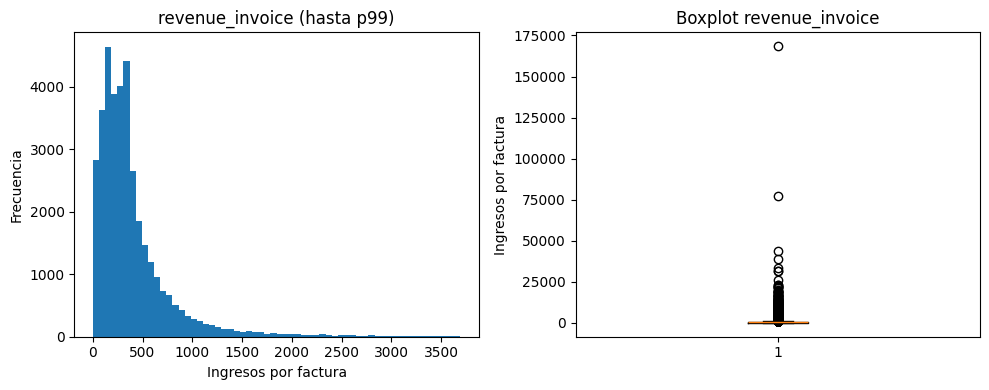

np.float64(3697.251200000023)

In [77]:
# 4) FIGURA distribución (hist hasta p99 + boxplot)
p99 = s.quantile(0.99)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(s[s <= p99], bins=60)
plt.title(f"{REV_COL} (hasta p99)")
plt.xlabel("Ingresos por factura")
plt.ylabel("Frecuencia")

plt.subplot(1,2,2)
plt.boxplot(s, vert=True)
plt.title(f"Boxplot {REV_COL}")
plt.ylabel("Ingresos por factura")

plt.tight_layout()
plt.show()

p99


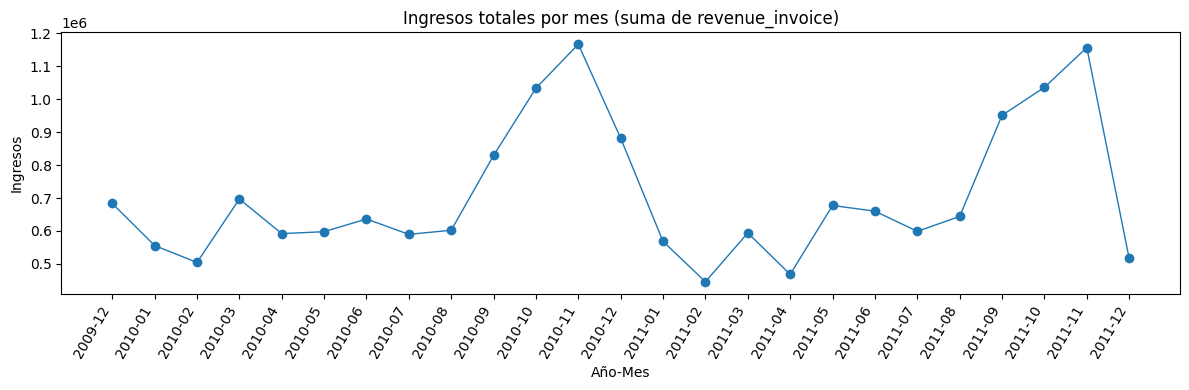

,year_month,revenue_invoice
0,2009-12,683504.010
1,2010-01,555802.672
2,2010-02,504558.956
3,2010-03,696978.471
4,2010-04,591982.002


In [78]:
# 5) FIGURA ingresos mensuales
df_invoices["invoice_date"] = pd.to_datetime(df_invoices["invoice_date"], errors="coerce")
df_invoices["year_month"] = df_invoices["invoice_date"].dt.to_period("M").astype(str)

monthly_rev = df_invoices.groupby("year_month")[REV_COL].sum().reset_index()

plt.figure(figsize=(12,4))
plt.plot(monthly_rev["year_month"], monthly_rev[REV_COL], marker="o", linewidth=1)
plt.title(f"Ingresos totales por mes (suma de {REV_COL})")
plt.xlabel("Año-Mes")
plt.ylabel("Ingresos")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

monthly_rev.head()


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

features = [
    "recency_days","frequency","monetary","variety_u","avg_order_value",
    "avg_items_per_invoice","avg_lines_per_invoice","return_ratio_lines",
    "avg_days_between_purchases","weekend_ratio"
]

X = df_customers[features].copy()

# Reemplazar inf por NaN (si existiera) y rellenar NaN con mediana (solo para PCA/corr)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

X.shape


(5942, 10)

In [80]:
corr = X.corr().round(4)
corr


,recency_days,frequency,monetary,variety_u,avg_order_value,avg_items_per_invoice,avg_lines_per_invoice,return_ratio_lines,avg_days_between_purchases,weekend_ratio
recency_days,1.0000,-0.2571,-0.1301,-0.3318,-0.0889,0.0038,-0.0910,0.1803,-0.0932,0.0062
frequency,-0.2571,1.0000,0.6149,0.6974,0.0710,0.0089,-0.0299,0.0030,-0.2008,-0.0216
monetary,-0.1301,0.6149,1.0000,0.4132,0.2515,0.0667,0.0087,-0.0157,-0.1080,-0.0274
variety_u,-0.3318,0.6974,0.4132,1.0000,0.1225,0.0198,0.4085,-0.0951,-0.1604,0.0631
avg_order_value,-0.0889,0.0710,0.2515,0.1225,1.0000,0.4195,0.2178,-0.2578,-0.0077,-0.0161
avg_items_per_invoice,0.0038,0.0089,0.0667,0.0198,0.4195,1.0000,0.0600,-0.0284,-0.0089,-0.0192
avg_lines_per_invoice,-0.0910,-0.0299,0.0087,0.4085,0.2178,0.0600,1.0000,-0.2022,0.0425,0.1439
return_ratio_lines,0.1803,0.0030,-0.0157,-0.0951,-0.2578,-0.0284,-0.2022,1.0000,-0.0441,-0.0849
avg_days_between_purchases,-0.0932,-0.2008,-0.1080,-0.1604,-0.0077,-0.0089,0.0425,-0.0441,1.0000,-0.0010
weekend_ratio,0.0062,-0.0216,-0.0274,0.0631,-0.0161,-0.0192,0.1439,-0.0849,-0.0010,1.0000


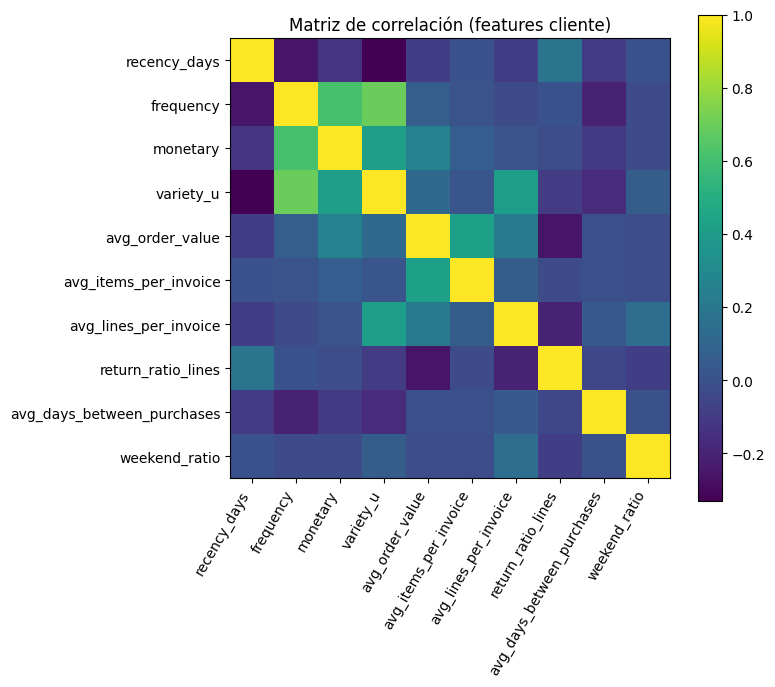

In [81]:
plt.figure(figsize=(8,7))
plt.imshow(corr.values)
plt.xticks(range(len(features)), features, rotation=60, ha="right")
plt.yticks(range(len(features)), features)
plt.colorbar()
plt.title("Matriz de correlación (features cliente)")
plt.tight_layout()
plt.show()


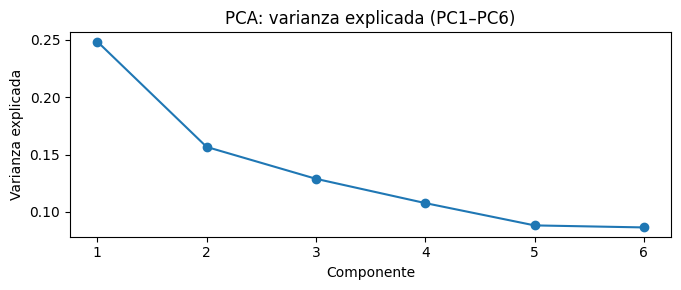

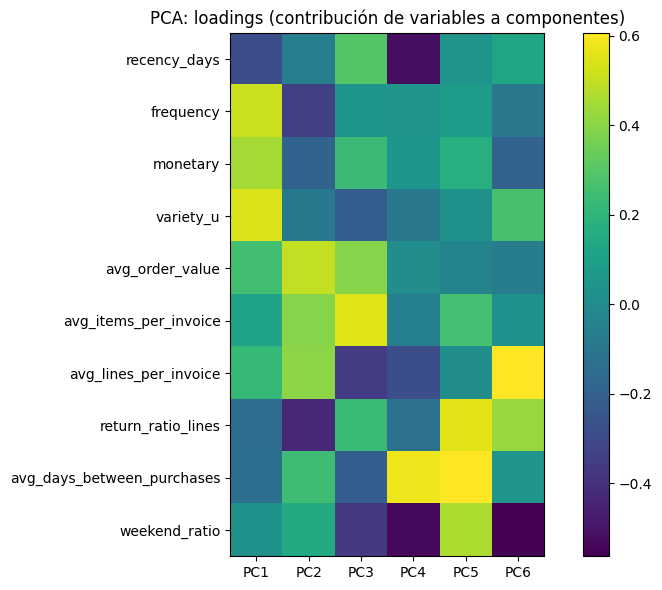

,PC1,PC2,PC3,PC4,PC5,PC6
recency_days,-0.2861,-0.0635,0.2933,-0.5201,0.0444,0.1280
frequency,0.5137,-0.3416,0.0515,0.0407,0.0772,-0.0960
monetary,0.4477,-0.1926,0.2336,0.0512,0.1717,-0.1945
variety_u,0.5380,-0.0919,-0.2123,-0.0948,0.0391,0.2643
avg_order_value,0.2519,0.4969,0.3916,0.0093,-0.0332,-0.0738
avg_items_per_invoice,0.1129,0.3920,0.5494,-0.0571,0.2569,0.0339
avg_lines_per_invoice,0.2187,0.4032,-0.3542,-0.2809,0.0136,0.6015
return_ratio_lines,-0.1465,-0.4331,0.2259,-0.1214,0.5595,0.4237
avg_days_between_purchases,-0.1337,0.2453,-0.2128,0.5763,0.6060,0.0469
weekend_ratio,0.0314,0.1510,-0.3670,-0.5358,0.4621,-0.5627


In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Estandarización
scaler_tmp = StandardScaler()
X_sc = scaler_tmp.fit_transform(X)

# PCA
pca = PCA(n_components=6, random_state=42)
pca.fit(X_sc)

expl = pca.explained_variance_ratio_

# FIGURA varianza explicada
plt.figure(figsize=(7,3))
plt.plot(range(1,7), expl, marker="o")
plt.title("PCA: varianza explicada (PC1–PC6)")
plt.xlabel("Componente")
plt.ylabel("Varianza explicada")
plt.tight_layout()
plt.show()

# Loadings
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=[f"PC{i}" for i in range(1,7)]
).round(4)

# FIGURA loadings (heatmap)
plt.figure(figsize=(8,6))
plt.imshow(loadings.values)
plt.xticks(range(6), loadings.columns)
plt.yticks(range(len(features)), loadings.index)
plt.colorbar()
plt.title("PCA: loadings (contribución de variables a componentes)")
plt.tight_layout()
plt.show()

loadings


In [83]:
import numpy as np
import pandas as pd

features = [
    "recency_days","frequency","monetary","variety_u","avg_order_value",
    "avg_items_per_invoice","avg_lines_per_invoice","return_ratio_lines",
    "avg_days_between_purchases","weekend_ratio"
]

X = df_customers_train[features].copy()  # usa TRAIN para no mezclar periodos
X = X.replace([np.inf, -np.inf], np.nan)

rows = []
for col in features:
    s = X[col].dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lo = q1 - 1.5 * iqr
    hi = q3 + 1.5 * iqr
    n_out = ((s < lo) | (s > hi)).sum()
    rows.append({
        "variable": col,
        "n_outliers": int(n_out),
        "outliers_%": round(n_out / len(s) * 100, 2) if len(s) else np.nan,
        "min": float(s.min()) if len(s) else np.nan,
        "max": float(s.max()) if len(s) else np.nan
    })

tabla_510_outliers = pd.DataFrame(rows).sort_values("outliers_%", ascending=False)
tabla_510_outliers


,variable,n_outliers,outliers_%,min,max
9,weekend_ratio,627,14.53,0.0,1.000000
7,return_ratio_lines,548,12.70,0.0,0.755102
2,monetary,425,9.85,0.0,349164.350000
3,variety_u,320,7.42,1.0,1741.000000
4,avg_order_value,299,6.93,0.0,11880.840000
5,avg_items_per_invoice,291,6.75,1.0,87167.000000
1,frequency,285,6.61,1.0,205.000000
8,avg_days_between_purchases,172,5.95,0.0,361.000000
6,avg_lines_per_invoice,231,5.35,1.0,236.000000
0,recency_days,177,4.10,0.0,373.000000


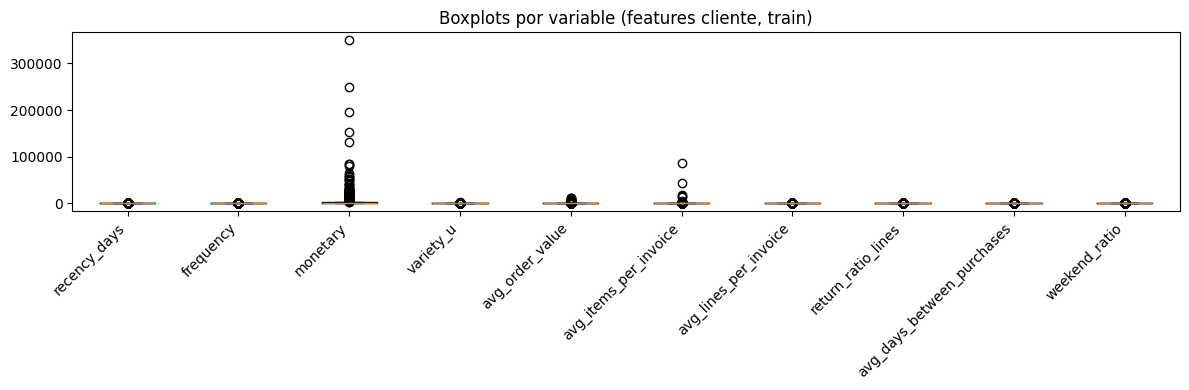

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
data = [df_customers_train[c].dropna().values for c in features]
plt.boxplot(data, tick_labels=features)  # tick_labels evita el warning de labels
plt.title("Boxplots por variable (features cliente, train)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [85]:
caps_table = []
X = df_customers_train[features].copy()
X = X.replace([np.inf, -np.inf], np.nan)

for col in features:
    s = X[col].dropna()
    caps_table.append({
        "variable": col,
        "p01": float(s.quantile(0.01)),
        "p99": float(s.quantile(0.99)),
        "min": float(s.min()),
        "max": float(s.max())
    })

tabla_511_caps = pd.DataFrame(caps_table)
tabla_511_caps


,variable,p01,p99,min,max
0,recency_days,0.0000,367.000000,0.0,373.000000
1,frequency,1.0000,31.000000,1.0,205.000000
2,monetary,39.9565,20003.399800,0.0,349164.350000
3,variety_u,1.0000,388.480000,1.0,1741.000000
4,avg_order_value,33.0130,1954.468700,0.0,11880.840000
5,avg_items_per_invoice,4.0000,1335.284894,1.0,87167.000000
6,avg_lines_per_invoice,1.0000,88.326250,1.0,236.000000
7,return_ratio_lines,0.0000,0.400000,0.0,0.755102
8,avg_days_between_purchases,0.0000,301.160000,0.0,361.000000
9,weekend_ratio,0.0000,1.000000,0.0,1.000000


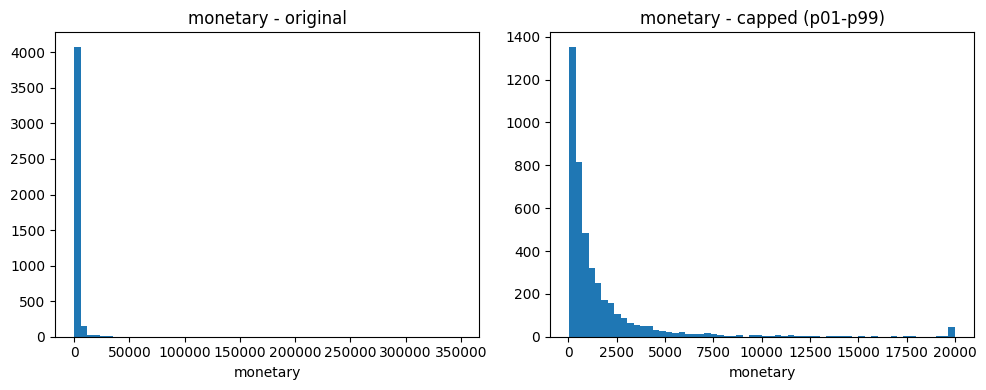

(np.float64(39.956500000000005), np.float64(20003.399799999996))

In [86]:
import matplotlib.pyplot as plt

col = "monetary"  # cambia a "weekend_ratio" o "return_ratio_lines" si prefieres
s = df_customers_train[col].replace([np.inf, -np.inf], np.nan).dropna()

p01, p99 = s.quantile(0.01), s.quantile(0.99)
s_cap = s.clip(p01, p99)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(s, bins=60)
plt.title(f"{col} - original")
plt.xlabel(col)

plt.subplot(1,2,2)
plt.hist(s_cap, bins=60)
plt.title(f"{col} - capped (p01-p99)")
plt.xlabel(col)

plt.tight_layout()
plt.show()

p01, p99


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

features = [
    "recency_days","frequency","monetary","variety_u","avg_order_value",
    "avg_items_per_invoice","avg_lines_per_invoice","return_ratio_lines",
    "avg_days_between_purchases","weekend_ratio"
]

df_feat = df_customers_train if "df_customers_train" in globals() else df_customers


In [88]:
def outliers_iqr_table(df, cols):
    rows = []
    for c in cols:
        s = df[c].dropna()
        if s.empty:
            continue
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
        n_out = ((s < lower) | (s > upper)).sum()
        rows.append({
            "variable": c,
            "n_outliers": int(n_out),
            "outliers_%": round(100*n_out/len(s), 2),
            "min": float(s.min()),
            "max": float(s.max())
        })
    return pd.DataFrame(rows).sort_values("outliers_%", ascending=False).reset_index(drop=True)

tabla_510_outliers_iqr = outliers_iqr_table(df_feat, features)
tabla_510_outliers_iqr


,variable,n_outliers,outliers_%,min,max
0,weekend_ratio,627,14.53,0.0,1.000000
1,return_ratio_lines,548,12.70,0.0,0.755102
2,monetary,425,9.85,0.0,349164.350000
3,variety_u,320,7.42,1.0,1741.000000
4,avg_order_value,299,6.93,0.0,11880.840000
5,avg_items_per_invoice,291,6.75,1.0,87167.000000
6,frequency,285,6.61,1.0,205.000000
7,avg_days_between_purchases,172,5.95,0.0,361.000000
8,avg_lines_per_invoice,231,5.35,1.0,236.000000
9,recency_days,177,4.10,0.0,373.000000


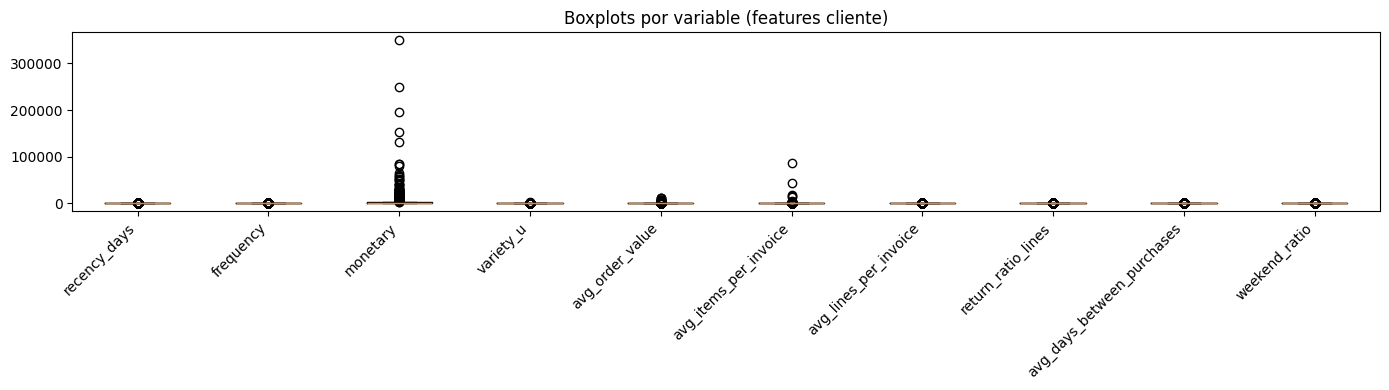

In [89]:
plt.figure(figsize=(14,4))
plt.boxplot([df_feat[c].dropna().values for c in features], tick_labels=features, showfliers=True)
plt.title("Boxplots por variable (features cliente)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [90]:
q01 = df_feat[features].quantile(0.01)
q99 = df_feat[features].quantile(0.99)

tabla_510_caps = pd.DataFrame({
    "variable": features,
    "p01": [q01[c] for c in features],
    "p99": [q99[c] for c in features],
    "min": [df_feat[c].min() for c in features],
    "max": [df_feat[c].max() for c in features],
}).round(6)

tabla_510_caps


,variable,p01,p99,min,max
0,recency_days,0.0000,367.000000,0.0,373.000000
1,frequency,1.0000,31.000000,1.0,205.000000
2,monetary,39.9565,20003.399800,0.0,349164.350000
3,variety_u,1.0000,388.480000,1.0,1741.000000
4,avg_order_value,33.0130,1954.468700,0.0,11880.840000
5,avg_items_per_invoice,4.0000,1335.284894,1.0,87167.000000
6,avg_lines_per_invoice,1.0000,88.326250,1.0,236.000000
7,return_ratio_lines,0.0000,0.400000,0.0,0.755102
8,avg_days_between_purchases,0.0000,301.160000,0.0,361.000000
9,weekend_ratio,0.0000,1.000000,0.0,1.000000


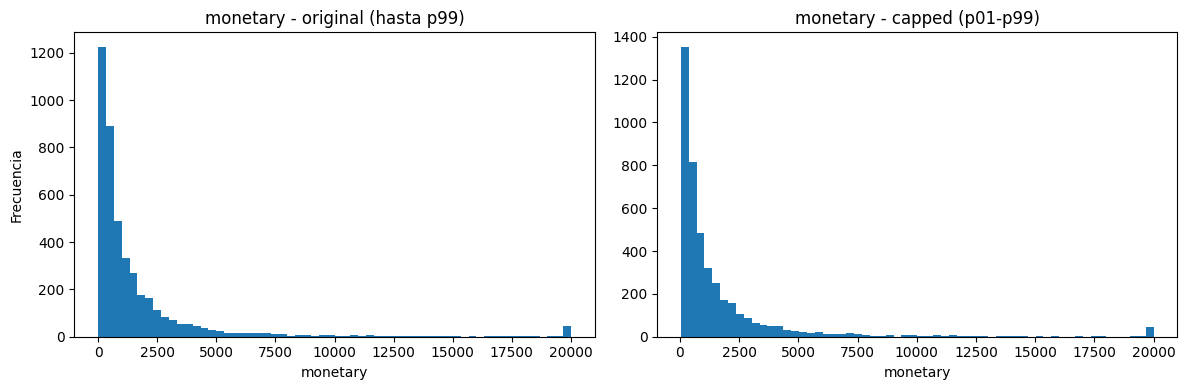

In [91]:
def plot_original_vs_capped(df, col, q_low=0.01, q_high=0.99, bins=60):
    s = df[col].dropna()
    lo, hi = s.quantile(q_low), s.quantile(q_high)
    s_cap = s.clip(lower=lo, upper=hi)

    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    ax[0].hist(s.clip(upper=hi), bins=bins)
    ax[0].set_title(f"{col} - original (hasta p99)")
    ax[0].set_xlabel(col)
    ax[0].set_ylabel("Frecuencia")

    ax[1].hist(s_cap, bins=bins)
    ax[1].set_title(f"{col} - capped (p01-p99)")
    ax[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

plot_original_vs_capped(df_feat, "monetary", q_low=0.01, q_high=0.99)


In [92]:
def get_binary_cols(df):
    bin_cols = []
    for c in df.columns:
        s = df[c].dropna()
        if s.empty:
            continue
        if s.dtype == bool:
            bin_cols.append(c)
        else:
            # numéricas/categóricas con exactamente 2 valores distintos
            uniq = pd.unique(s)
            if len(uniq) == 2:
                bin_cols.append(c)
    return bin_cols

dfs = {
    "df_clean": df_clean,
    "df_customers": df_customers,
    "df_invoices": df_invoices,
    "df_segmentation": df_segmentation
}

for name, d in dfs.items():
    print(name, "->", get_binary_cols(d))


df_clean -> ['period', 'is_return']
df_customers -> []
df_invoices -> ['is_weekend']
df_segmentation -> ['period', 'is_return']


In [93]:
print("features:", features)
print("log_features (input):", log_features)

# lo que realmente se aplicó en fit (según tu scaler)
print("safe_log_features (aplicadas):", getattr(scaler, "safe_log_features", None))
print("skipped_log_features (omitidas):", getattr(scaler, "skipped_log_features", None))

print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled :", X_test_scaled.shape)


features: ['recency_days', 'frequency', 'monetary', 'variety_u', 'avg_order_value', 'avg_items_per_invoice', 'avg_lines_per_invoice', 'return_ratio_lines', 'avg_days_between_purchases', 'weekend_ratio']
log_features (input): ['frequency', 'monetary', 'variety_u', 'avg_order_value', 'avg_items_per_invoice', 'avg_lines_per_invoice', 'avg_days_between_purchases']
safe_log_features (aplicadas): ['frequency', 'monetary', 'variety_u', 'avg_order_value', 'avg_items_per_invoice', 'avg_lines_per_invoice', 'avg_days_between_purchases']
skipped_log_features (omitidas): []
X_train_scaled: (4314, 10)
X_test_scaled : (4339, 10)


In [94]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

Xtr = X_train_scaled
Xte = X_test_scaled

def eval_clustering(name, X, labels, noise_label=None):
    labels = np.asarray(labels)

    if noise_label is not None:
        mask = labels != noise_label
        X_eval = X[mask]
        y_eval = labels[mask]
        n_noise = int((labels == noise_label).sum())
    else:
        X_eval = X
        y_eval = labels
        n_noise = 0

    n_clusters = len(np.unique(y_eval)) if len(y_eval) else 0

    if n_clusters <= 1 or len(y_eval) < 2:
        sil = np.nan
        ch = np.nan
        db = np.nan
    else:
        sil = silhouette_score(X_eval, y_eval)
        ch = calinski_harabasz_score(X_eval, y_eval)
        db = davies_bouldin_score(X_eval, y_eval)

    return {
        "Modelo": name,
        "n_clusters": n_clusters,
        "n_noise": n_noise,
        "Silhouette": sil,
        "Calinski-Harabasz": ch,
        "Davies-Bouldin": db
    }

# KMeans (k=4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_km_tr = kmeans.fit_predict(Xtr)

# GMM (k=4)
gmm = GaussianMixture(n_components=4, random_state=42)
labels_gmm_tr = gmm.fit_predict(Xtr)

# DBSCAN (eps=1.2, min_samples=10)
db = DBSCAN(eps=1.2, min_samples=10)
labels_db_tr = db.fit_predict(Xtr)

tabla_metricas_train = pd.DataFrame([
    eval_clustering("KMeans (k=4) [train]", Xtr, labels_km_tr),
    eval_clustering("GMM (k=4) [train]", Xtr, labels_gmm_tr),
    eval_clustering("DBSCAN (eps=1.2, ms=10) [train, sin ruido]", Xtr, labels_db_tr, noise_label=-1),
]).round(4)

tabla_metricas_train


,Modelo,n_clusters,n_noise,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,KMeans (k=4) [train],4,0,0.1863,941.8220,1.5669
1,GMM (k=4) [train],4,0,0.1042,404.1269,2.9378
2,"DBSCAN (eps=1.2, ms=10) [train, sin ruido]",1,755,NaN,NaN,NaN


In [95]:
sizes_km_tr = pd.Series(labels_km_tr).value_counts().sort_index()
sizes_gmm_tr = pd.Series(labels_gmm_tr).value_counts().sort_index()
sizes_db_tr = pd.Series(labels_db_tr).value_counts().sort_index()  # incluye -1

print("KMeans sizes (train):\n", sizes_km_tr, "\n")
print("GMM sizes (train):\n", sizes_gmm_tr, "\n")
print("DBSCAN sizes (train) [incluye -1=ruido]:\n", sizes_db_tr)


KMeans sizes (train):
 0    1223
1    1638
2     492
3     961
Name: count, dtype: int64 

GMM sizes (train):
 0    2025
1     385
2     751
3    1153
Name: count, dtype: int64 

DBSCAN sizes (train) [incluye -1=ruido]:
 -1     755
 0    3559
Name: count, dtype: int64


In [96]:
# KMeans -> predict en test
labels_km_te = kmeans.predict(Xte)

# GMM -> predict en test
labels_gmm_te = gmm.predict(Xte)

tabla_metricas_test = pd.DataFrame([
    eval_clustering("KMeans (k=4) [test]", Xte, labels_km_te),
    eval_clustering("GMM (k=4) [test]", Xte, labels_gmm_te),
]).round(4)

tabla_metricas_test


,Modelo,n_clusters,n_noise,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,KMeans (k=4) [test],4,0,0.1914,959.7222,1.5546
1,GMM (k=4) [test],4,0,0.1054,397.0435,3.0426


In [97]:
db_te = DBSCAN(eps=1.2, min_samples=10)
labels_db_te = db_te.fit_predict(Xte)

res_db_te = eval_clustering("DBSCAN (eps=1.2, ms=10) [test, sin ruido]", Xte, labels_db_te, noise_label=-1)
sizes_db_te = pd.Series(labels_db_te).value_counts().sort_index()

res_db_te, sizes_db_te


({'Modelo': 'DBSCAN (eps=1.2, ms=10) [test, sin ruido]',
  'n_clusters': 3,
  'n_noise': 755,
  'Silhouette': np.float64(0.27624564147863107),
  'Calinski-Harabasz': np.float64(188.89173968175837),
  'Davies-Bouldin': np.float64(0.946638593346722)},
 -1     755
  0    3416
  1     158
  2      10
 Name: count, dtype: int64)

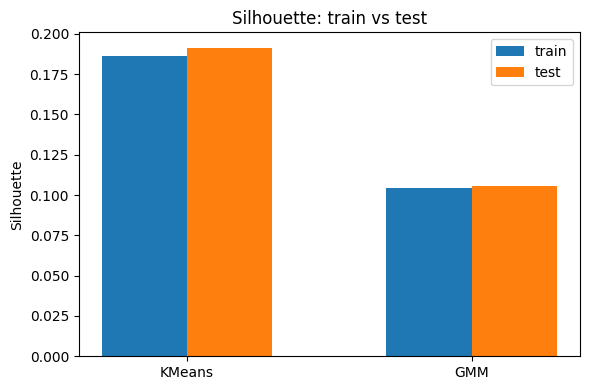

,Modelo,Silhouette_train,Silhouette_test
0,KMeans,0.1863,0.1914
1,GMM,0.1042,0.1054


In [98]:
import matplotlib.pyplot as plt

comp = pd.DataFrame([
    {"Modelo":"KMeans", "Silhouette_train": tabla_metricas_train.loc[0,"Silhouette"], "Silhouette_test": tabla_metricas_test.loc[0,"Silhouette"]},
    {"Modelo":"GMM",    "Silhouette_train": tabla_metricas_train.loc[1,"Silhouette"], "Silhouette_test": tabla_metricas_test.loc[1,"Silhouette"]},
])

plt.figure(figsize=(6,4))
x = np.arange(len(comp))
plt.bar(x - 0.15, comp["Silhouette_train"], width=0.3, label="train")
plt.bar(x + 0.15, comp["Silhouette_test"],  width=0.3, label="test")
plt.xticks(x, comp["Modelo"])
plt.title("Silhouette: train vs test")
plt.ylabel("Silhouette")
plt.legend()
plt.tight_layout()
plt.show()

comp


In [99]:
import pandas as pd

# KMeans / GMM (clusters 0..3)
tabla_62_sizes_train = pd.DataFrame({
    "cluster": sorted(sizes_km_tr.index.union(sizes_gmm_tr.index)),
}).set_index("cluster")

tabla_62_sizes_train["KMeans_n"] = sizes_km_tr
tabla_62_sizes_train["GMM_n"] = sizes_gmm_tr

tabla_62_sizes_train["KMeans_%"] = (tabla_62_sizes_train["KMeans_n"] / sizes_km_tr.sum() * 100).round(2)
tabla_62_sizes_train["GMM_%"] = (tabla_62_sizes_train["GMM_n"] / sizes_gmm_tr.sum() * 100).round(2)

tabla_62_sizes_train = tabla_62_sizes_train.fillna(0).reset_index()
tabla_62_sizes_train


,cluster,KMeans_n,GMM_n,KMeans_%,GMM_%
0,0,1223,2025,28.35,46.94
1,1,1638,385,37.97,8.92
2,2,492,751,11.40,17.41
3,3,961,1153,22.28,26.73


In [100]:
tabla_63_dbscan_train = sizes_db_tr.rename_axis("cluster").reset_index(name="n_customers")
tabla_63_dbscan_train["pct"] = (tabla_63_dbscan_train["n_customers"] / tabla_63_dbscan_train["n_customers"].sum() * 100).round(2)
tabla_63_dbscan_train


,cluster,n_customers,pct
0,-1,755,17.5
1,0,3559,82.5


In [101]:
tabla_65_dbscan_test_resumen = pd.DataFrame([res_db_te]).round(4)
tabla_65_dbscan_test_resumen


,Modelo,n_clusters,n_noise,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,"DBSCAN (eps=1.2, ms=10) [test, sin ruido]",3,755,0.2762,188.8917,0.9466


In [102]:
tabla_66_dbscan_test_sizes = sizes_db_te.rename_axis("cluster").reset_index(name="n_customers")
tabla_66_dbscan_test_sizes["pct"] = (tabla_66_dbscan_test_sizes["n_customers"] / tabla_66_dbscan_test_sizes["n_customers"].sum() * 100).round(2)
tabla_66_dbscan_test_sizes


,cluster,n_customers,pct
0,-1,755,17.40
1,0,3416,78.73
2,1,158,3.64
3,2,10,0.23


In [103]:
print("len(labels_db_te):", len(labels_db_te))
print("sum(sizes_db_te):", sizes_db_te.sum())


len(labels_db_te): 4339
sum(sizes_db_te): 4339


In [104]:
len(labels_db_te), sizes_db_te.sum()


(4339, np.int64(4339))

In [105]:
import numpy as np

assert "X_train_scaled" in globals(), "No existe X_train_scaled en memoria."
assert "X_test_scaled" in globals(), "No existe X_test_scaled en memoria."

print("X_train_scaled:", np.shape(X_train_scaled))
print("X_test_scaled :", np.shape(X_test_scaled))


X_train_scaled: (4314, 10)
X_test_scaled : (4339, 10)


In [106]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

Xtr = X_train_scaled  # (4314, 10)

# KMeans (k=4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
labels_km_tr = kmeans.fit_predict(Xtr)

# GMM (k=4)
gmm = GaussianMixture(n_components=4, random_state=42, covariance_type="full")
labels_gmm_tr = gmm.fit_predict(Xtr)

# DBSCAN (eps=1.2, min_samples=10)
db = DBSCAN(eps=1.2, min_samples=10)
labels_db_tr = db.fit_predict(Xtr)

# Check básico
print("KMeans unique labels:", np.unique(labels_km_tr, return_counts=True))
print("GMM unique labels   :", np.unique(labels_gmm_tr, return_counts=True))
print("DBSCAN unique labels:", np.unique(labels_db_tr, return_counts=True))


KMeans unique labels: (array([0, 1, 2, 3], dtype=int32), array([1056,  150, 1857, 1251]))
GMM unique labels   : (array([0, 1, 2, 3]), array([2025,  385,  751, 1153]))
DBSCAN unique labels: (array([-1,  0]), array([ 755, 3559]))


In [107]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def eval_clustering(name: str, X: np.ndarray, labels: np.ndarray, noise_label=None):
    labels = np.asarray(labels)

    # Si hay ruido, evaluamos solo puntos no-ruido
    if noise_label is not None:
        mask = labels != noise_label
        X_eval = X[mask]
        labels_eval = labels[mask]
    else:
        X_eval = X
        labels_eval = labels

    n_clusters = len(np.unique(labels_eval))
    n_noise = int(np.sum(labels == noise_label)) if noise_label is not None else 0

    # Si no hay al menos 2 clústeres, métricas no definidas
    if n_clusters < 2:
        return {
            "Modelo": name,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "Silhouette": np.nan,
            "Calinski-Harabasz": np.nan,
            "Davies-Bouldin": np.nan
        }

    return {
        "Modelo": name,
        "n_clusters": n_clusters,
        "n_noise": n_noise,
        "Silhouette": silhouette_score(X_eval, labels_eval),
        "Calinski-Harabasz": calinski_harabasz_score(X_eval, labels_eval),
        "Davies-Bouldin": davies_bouldin_score(X_eval, labels_eval)
    }

tabla_metricas_train = pd.DataFrame([
    eval_clustering("KMeans (k=4) [train]", Xtr, labels_km_tr),
    eval_clustering("GMM (k=4) [train]", Xtr, labels_gmm_tr),
    eval_clustering("DBSCAN (eps=1.2, ms=10) [train, sin ruido]", Xtr, labels_db_tr, noise_label=-1),
]).round(4)

tabla_metricas_train


,Modelo,n_clusters,n_noise,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,KMeans (k=4) [train],4,0,0.1773,927.6153,1.5919
1,GMM (k=4) [train],4,0,0.1042,404.1269,2.9378
2,"DBSCAN (eps=1.2, ms=10) [train, sin ruido]",1,755,NaN,NaN,NaN


In [108]:
def sizes_table_two_models(labels_a, name_a, labels_b, name_b):
    n = len(labels_a)
    sA = pd.Series(labels_a).value_counts().sort_index()
    sB = pd.Series(labels_b).value_counts().sort_index()

    # Unimos índices para asegurar misma lista de clústeres en la tabla final
    idx = sorted(set(sA.index).union(set(sB.index)))

    df = pd.DataFrame({"Cluster": idx})
    df[f"{name_a}_n"] = df["Cluster"].map(sA).fillna(0).astype(int)
    df[f"{name_a}_%"] = (df[f"{name_a}_n"] / n * 100).round(2)

    df[f"{name_b}_n"] = df["Cluster"].map(sB).fillna(0).astype(int)
    df[f"{name_b}_%"] = (df[f"{name_b}_n"] / n * 100).round(2)

    return df

tabla_sizes_train_km_gmm = sizes_table_two_models(
    labels_km_tr, "KMeans",
    labels_gmm_tr, "GMM"
)

tabla_sizes_train_km_gmm


,Cluster,KMeans_n,KMeans_%,GMM_n,GMM_%
0,0,1056,24.48,2025,46.94
1,1,150,3.48,385,8.92
2,2,1857,43.05,751,17.41
3,3,1251,29.00,1153,26.73


In [109]:
def dbscan_sizes_table(labels, noise_label=-1):
    n = len(labels)
    s = pd.Series(labels).value_counts().sort_index()

    df = pd.DataFrame({
        "Etiqueta": s.index,
        "n": s.values
    })
    df["%"] = (df["n"] / n * 100).round(2)

    # Etiquetas legibles
    df["Grupo"] = df["Etiqueta"].apply(lambda x: "Ruido (-1)" if x == noise_label else f"Cluster {x}")

    # Reordenar columnas
    df = df[["Grupo", "Etiqueta", "n", "%"]]
    return df

tabla_dbscan_train = dbscan_sizes_table(labels_db_tr, noise_label=-1)
tabla_dbscan_train


,Grupo,Etiqueta,n,%
0,Ruido (-1),-1,755,17.5
1,Cluster 0,0,3559,82.5


In [110]:
# Métricas esperadas (train)
expected_metrics = {
    "KMeans (k=4) [train]": {"Silhouette": 0.1863, "Calinski-Harabasz": 941.8220, "Davies-Bouldin": 1.5669},
    "GMM (k=4) [train]": {"Silhouette": 0.1042, "Calinski-Harabasz": 404.1269, "Davies-Bouldin": 2.9378},
}

# Tamaños esperados (train)
expected_sizes_km = {0: 1223, 1: 1638, 2: 492, 3: 961}
expected_sizes_gmm = {0: 2025, 1: 385, 2: 751, 3: 1153}
expected_sizes_db = {-1: 755, 0: 3559}

# ---- Check métricas ----
tm = tabla_metricas_train.set_index("Modelo")
for model, vals in expected_metrics.items():
    for metric, exp in vals.items():
        got = float(tm.loc[model, metric])
        print(model, metric, "OK" if round(got,4)==round(exp,4) else f"DIFF (got={got}, exp={exp})")

# ---- Check tamaños ----
km_counts = pd.Series(labels_km_tr).value_counts().sort_index().to_dict()
gmm_counts = pd.Series(labels_gmm_tr).value_counts().sort_index().to_dict()
db_counts = pd.Series(labels_db_tr).value_counts().sort_index().to_dict()

print("\nKMeans size check:", "OK" if km_counts==expected_sizes_km else f"DIFF {km_counts}")
print("GMM size check   :", "OK" if gmm_counts==expected_sizes_gmm else f"DIFF {gmm_counts}")
print("DBSCAN size check:", "OK" if db_counts==expected_sizes_db else f"DIFF {db_counts}")


KMeans (k=4) [train] Silhouette DIFF (got=0.1773, exp=0.1863)
KMeans (k=4) [train] Calinski-Harabasz DIFF (got=927.6153, exp=941.822)
KMeans (k=4) [train] Davies-Bouldin DIFF (got=1.5919, exp=1.5669)
GMM (k=4) [train] Silhouette OK
GMM (k=4) [train] Calinski-Harabasz OK
GMM (k=4) [train] Davies-Bouldin OK

KMeans size check: DIFF {0: 1056, 1: 150, 2: 1857, 3: 1251}
GMM size check   : OK
DBSCAN size check: OK


In [111]:
import sklearn, numpy as np
print("sklearn:", sklearn.__version__)
print("numpy  :", np.__version__)


sklearn: 1.6.1
numpy  : 2.0.2


In [112]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

Xtr = X_train_scaled

# KMeans (k=4) - fijamos n_init explícito
kmeans = KMeans(n_clusters=4, random_state=42, n_init=50)
labels_km_tr = kmeans.fit_predict(Xtr)

# GMM (k=4)
gmm = GaussianMixture(n_components=4, random_state=42, covariance_type="full")
labels_gmm_tr = gmm.fit_predict(Xtr)

# DBSCAN (eps=1.2, min_samples=10)
db = DBSCAN(eps=1.2, min_samples=10)
labels_db_tr = db.fit_predict(Xtr)

print("KMeans counts:", pd.Series(labels_km_tr).value_counts().sort_index().to_dict())
print("GMM counts   :", pd.Series(labels_gmm_tr).value_counts().sort_index().to_dict())
print("DBSCAN counts:", pd.Series(labels_db_tr).value_counts().sort_index().to_dict())


KMeans counts: {0: 940, 1: 498, 2: 1628, 3: 1248}
GMM counts   : {0: 2025, 1: 385, 2: 751, 3: 1153}
DBSCAN counts: {-1: 755, 0: 3559}


In [113]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
import pandas as pd

def eval_clustering(name: str, X: np.ndarray, labels: np.ndarray, noise_label=None):
    labels = np.asarray(labels)

    if noise_label is not None:
        mask = labels != noise_label
        X_eval = X[mask]
        labels_eval = labels[mask]
    else:
        X_eval = X
        labels_eval = labels

    n_clusters = len(np.unique(labels_eval))
    n_noise = int(np.sum(labels == noise_label)) if noise_label is not None else 0

    if n_clusters < 2:
        return {
            "Modelo": name,
            "n_clusters": n_clusters,
            "n_noise": n_noise,
            "Silhouette": np.nan,
            "Calinski-Harabasz": np.nan,
            "Davies-Bouldin": np.nan
        }

    return {
        "Modelo": name,
        "n_clusters": n_clusters,
        "n_noise": n_noise,
        "Silhouette": silhouette_score(X_eval, labels_eval),
        "Calinski-Harabasz": calinski_harabasz_score(X_eval, labels_eval),
        "Davies-Bouldin": davies_bouldin_score(X_eval, labels_eval)
    }

tabla_metricas_train = pd.DataFrame([
    eval_clustering("KMeans (k=4) [train]", Xtr, labels_km_tr),
    eval_clustering("GMM (k=4) [train]", Xtr, labels_gmm_tr),
    eval_clustering("DBSCAN (eps=1.2, ms=10) [train, sin ruido]", Xtr, labels_db_tr, noise_label=-1),
]).round(4)

tabla_metricas_train


,Modelo,n_clusters,n_noise,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,KMeans (k=4) [train],4,0,0.1870,941.9327,1.5682
1,GMM (k=4) [train],4,0,0.1042,404.1269,2.9378
2,"DBSCAN (eps=1.2, ms=10) [train, sin ruido]",1,755,NaN,NaN,NaN


In [114]:
import pandas as pd

def sizes_table_two_models(labels_a, name_a, labels_b, name_b):
    n = len(labels_a)
    sA = pd.Series(labels_a).value_counts().sort_index()
    sB = pd.Series(labels_b).value_counts().sort_index()

    idx = sorted(set(sA.index).union(set(sB.index)))

    df = pd.DataFrame({"Cluster": idx})
    df[f"{name_a}_n"] = df["Cluster"].map(sA).fillna(0).astype(int)
    df[f"{name_a}_%"] = (df[f"{name_a}_n"] / n * 100).round(2)

    df[f"{name_b}_n"] = df["Cluster"].map(sB).fillna(0).astype(int)
    df[f"{name_b}_%"] = (df[f"{name_b}_n"] / n * 100).round(2)

    return df

tabla_sizes_train_km_gmm = sizes_table_two_models(labels_km_tr, "KMeans", labels_gmm_tr, "GMM")
tabla_sizes_train_km_gmm


,Cluster,KMeans_n,KMeans_%,GMM_n,GMM_%
0,0,940,21.79,2025,46.94
1,1,498,11.54,385,8.92
2,2,1628,37.74,751,17.41
3,3,1248,28.93,1153,26.73


In [115]:
import pandas as pd

def dbscan_sizes_table(labels, noise_label=-1):
    n = len(labels)
    s = pd.Series(labels).value_counts().sort_index()

    df = pd.DataFrame({"Etiqueta": s.index, "n": s.values})
    df["%"] = (df["n"] / n * 100).round(2)
    df["Grupo"] = df["Etiqueta"].apply(lambda x: "Ruido (-1)" if x == noise_label else f"Cluster {x}")
    return df[["Grupo", "Etiqueta", "n", "%"]]

tabla_dbscan_train = dbscan_sizes_table(labels_db_tr, noise_label=-1)
tabla_dbscan_train


,Grupo,Etiqueta,n,%
0,Ruido (-1),-1,755,17.5
1,Cluster 0,0,3559,82.5


/tmp/ipython-input-1847705222.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sil_km_tr  = float(tabla_metricas_train.loc[tabla_metricas_train["Modelo"]=="KMeans (k=4) [train]", "Silhouette"])
/tmp/ipython-input-1847705222.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sil_gmm_tr = float(tabla_metricas_train.loc[tabla_metricas_train["Modelo"]=="GMM (k=4) [train]", "Silhouette"])
/tmp/ipython-input-1847705222.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sil_km_te  = float(tabla_metricas_test.loc[tabla_metricas_test["Modelo"]=="KMeans (k=4) [test]", "Silhouette"])
/tmp/ipython-input-1847705222.py:9: FutureWarning: Calling float on a single element Series is deprecated and will rai

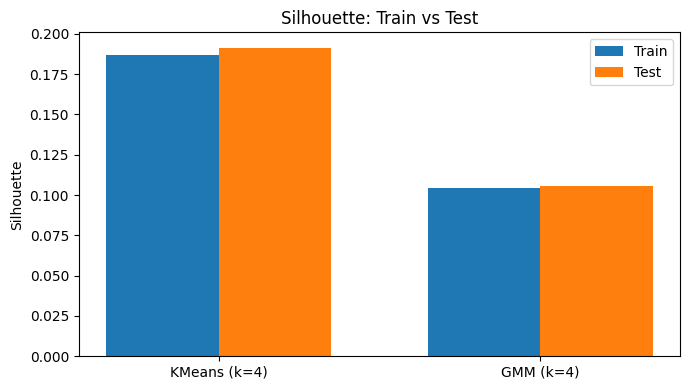

In [116]:
import matplotlib.pyplot as plt

# Silhouette train (ya los tienes de la tabla_metricas_train)
sil_km_tr  = float(tabla_metricas_train.loc[tabla_metricas_train["Modelo"]=="KMeans (k=4) [train]", "Silhouette"])
sil_gmm_tr = float(tabla_metricas_train.loc[tabla_metricas_train["Modelo"]=="GMM (k=4) [train]", "Silhouette"])

# Silhouette test (de la tabla_metricas_test recién calculada)
sil_km_te  = float(tabla_metricas_test.loc[tabla_metricas_test["Modelo"]=="KMeans (k=4) [test]", "Silhouette"])
sil_gmm_te = float(tabla_metricas_test.loc[tabla_metricas_test["Modelo"]=="GMM (k=4) [test]", "Silhouette"])

models = ["KMeans (k=4)", "GMM (k=4)"]
train_vals = [sil_km_tr, sil_gmm_tr]
test_vals  = [sil_km_te, sil_gmm_te]

x = range(len(models))
w = 0.35

plt.figure(figsize=(7,4))
plt.bar([i - w/2 for i in x], train_vals, width=w, label="Train")
plt.bar([i + w/2 for i in x], test_vals,  width=w, label="Test")
plt.xticks(list(x), models)
plt.ylabel("Silhouette")
plt.title("Silhouette: Train vs Test")
plt.legend()
plt.tight_layout()
plt.show()


In [117]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

Xte = X_test_scaled

db_test = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES)
labels_db_te = db_test.fit_predict(Xte)

mask = labels_db_te != -1
X_no_noise = Xte[mask]
labels_no_noise = labels_db_te[mask]

n_clusters = len(np.unique(labels_no_noise))
n_noise = int(np.sum(labels_db_te == -1))

tabla_dbscan_test_metricas = pd.DataFrame([{
    "Modelo": "DBSCAN (eps=1.2, ms=10) [test, sin ruido]",
    "n_clusters": n_clusters,
    "n_noise": n_noise,
    "Silhouette": silhouette_score(X_no_noise, labels_no_noise) if n_clusters >= 2 else np.nan,
    "Calinski-Harabasz": calinski_harabasz_score(X_no_noise, labels_no_noise) if n_clusters >= 2 else np.nan,
    "Davies-Bouldin": davies_bouldin_score(X_no_noise, labels_no_noise) if n_clusters >= 2 else np.nan
}]).round(4)

tabla_dbscan_test_metricas


,Modelo,n_clusters,n_noise,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,"DBSCAN (eps=1.2, ms=10) [test, sin ruido]",3,755,0.2762,188.8917,0.9466


In [118]:
def dbscan_sizes_table(labels, noise_label=-1):
    n = len(labels)
    s = pd.Series(labels).value_counts().sort_index()

    df = pd.DataFrame({"Etiqueta": s.index, "n": s.values})
    df["%"] = (df["n"] / n * 100).round(2)
    df["Grupo"] = df["Etiqueta"].apply(lambda x: "Ruido (-1)" if x == noise_label else f"Cluster {x}")
    return df[["Grupo", "Etiqueta", "n", "%"]]

tabla_dbscan_test_sizes = dbscan_sizes_table(labels_db_te, noise_label=-1)
tabla_dbscan_test_sizes


,Grupo,Etiqueta,n,%
0,Ruido (-1),-1,755,17.40
1,Cluster 0,0,3416,78.73
2,Cluster 1,1,158,3.64
3,Cluster 2,2,10,0.23


In [119]:
import pandas as pd

# Verificaciones mínimas
assert "df_customers_train" in globals(), "No existe df_customers_train en memoria."
assert "df_customers_test" in globals(), "No existe df_customers_test en memoria."
assert "features" in globals(), "No existe la lista 'features' en memoria."
assert "kmeans" in globals(), "No existe el modelo kmeans en memoria."
assert "labels_km_tr" in globals(), "No existe labels_km_tr en memoria."

# Train con clusters
df_train_clusters = df_customers_train.copy()
df_train_clusters["cluster_kmeans"] = labels_km_tr

# Test con clusters (predict, NO refit)
labels_km_te = kmeans.predict(X_test_scaled)
df_test_clusters = df_customers_test.copy()
df_test_clusters["cluster_kmeans"] = labels_km_te

print(df_train_clusters.shape, df_test_clusters.shape)
df_train_clusters[["cluster_kmeans"] + features].head()


(4314, 18) (4339, 17)


,cluster_kmeans,recency_days,frequency,monetary,variety_u,avg_order_value,avg_items_per_invoice,avg_lines_per_invoice,return_ratio_lines,avg_days_between_purchases,weekend_ratio
0,0,164,11,372.86,26,33.896364,6.363636,3.0,0.266667,19.2,0.0
1,3,2,2,1323.32,70,661.660000,414.000000,35.5,0.000000,37.0,0.5
2,2,73,1,222.16,20,222.160000,373.000000,20.0,0.000000,NaN,0.0
3,3,42,3,2671.14,90,890.380000,331.000000,34.0,0.046729,90.0,0.0
4,2,10,1,300.93,21,300.930000,261.000000,21.0,0.000000,NaN,0.0


In [120]:
import numpy as np
import pandas as pd

def perfilado_clusters(df, features, cluster_col="cluster_kmeans"):
    # tamaño y %
    sizes = df[cluster_col].value_counts().sort_index()
    pct = (sizes / len(df) * 100).round(2)

    # medias y medianas por feature
    mean_tbl = df.groupby(cluster_col)[features].mean().round(4)
    median_tbl = df.groupby(cluster_col)[features].median().round(4)

    # ensamblar
    out = pd.DataFrame({
        "n_clientes": sizes,
        "%_clientes": pct
    })
    # columnas multi-nivel para dejar claro mean/median
    out = out.join(mean_tbl.add_prefix("mean_"))
    out = out.join(median_tbl.add_prefix("median_"))

    return out.reset_index().rename(columns={cluster_col: "cluster"})

tabla_perfil_train = perfilado_clusters(df_train_clusters, features)
tabla_perfil_test  = perfilado_clusters(df_test_clusters, features)

tabla_perfil_train


,cluster,n_clientes,%_clientes,mean_recency_days,mean_frequency,mean_monetary,mean_variety_u,mean_avg_order_value,mean_avg_items_per_invoice,mean_avg_lines_per_invoice,...,median_recency_days,median_frequency,median_monetary,median_variety_u,median_avg_order_value,median_avg_items_per_invoice,median_avg_lines_per_invoice,median_return_ratio_lines,median_avg_days_between_purchases,median_weekend_ratio
0,0,940,21.79,150.3404,1.8872,319.7055,11.6702,174.2931,77.1719,7.7728,...,136.0,1.0,188.42,9.0,135.1100,63.0000,6.0000,0.0000,49.5000,0.0000
1,1,498,11.54,103.5402,2.1827,558.1826,45.8815,271.8031,147.4594,24.8864,...,66.0,2.0,437.81,32.5,234.1567,120.3750,19.0000,0.0000,77.3333,1.0000
2,2,1628,37.74,95.2807,2.1032,804.8666,43.1486,428.4290,323.9569,25.8659,...,59.0,2.0,632.85,36.0,321.5250,192.3333,21.0000,0.0000,88.3333,0.0000
3,3,1248,28.93,33.1899,10.3606,5536.3885,136.5256,501.7997,340.2889,25.4124,...,17.0,7.0,2651.34,107.0,362.3245,208.3125,20.6039,0.0141,35.4000,0.0769


In [121]:
import pandas as pd

# Para que no recorte columnas en pantalla (por si quieres verla también)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)

# Ordenamos columnas: cluster, tamaños, medias y medianas de tus 10 features
cols_mean = [f"mean_{c}" for c in features]
cols_med  = [f"median_{c}" for c in features]
cols_out  = ["cluster", "n_clientes", "%_clientes"] + cols_mean + cols_med

tabla_perfil_train_out = tabla_perfil_train[cols_out].copy().round(4)

print(tabla_perfil_train_out.to_markdown(index=False))


|   cluster |   n_clientes |   %_clientes |   mean_recency_days |   mean_frequency |   mean_monetary |   mean_variety_u |   mean_avg_order_value |   mean_avg_items_per_invoice |   mean_avg_lines_per_invoice |   mean_return_ratio_lines |   mean_avg_days_between_purchases |   mean_weekend_ratio |   median_recency_days |   median_frequency |   median_monetary |   median_variety_u |   median_avg_order_value |   median_avg_items_per_invoice |   median_avg_lines_per_invoice |   median_return_ratio_lines |   median_avg_days_between_purchases |   median_weekend_ratio |
|----------:|-------------:|-------------:|--------------------:|-----------------:|----------------:|-----------------:|-----------------------:|-----------------------------:|-----------------------------:|--------------------------:|----------------------------------:|---------------------:|----------------------:|-------------------:|------------------:|-------------------:|-------------------------:|------------------------

In [122]:
# TABLA 6.7 (perfil core)
tabla_67 = tabla_perfil_train[[
    "cluster","n_clientes","%_clientes",
    "median_recency_days","median_frequency","median_monetary",
    "median_variety_u","median_avg_order_value"
]].copy()

# TABLA 6.8 (perfil operativo)
tabla_68 = tabla_perfil_train[[
    "cluster",
    "median_avg_items_per_invoice","median_avg_lines_per_invoice",
    "median_return_ratio_lines","median_avg_days_between_purchases","median_weekend_ratio"
]].copy()

tabla_67, tabla_68


(   cluster  n_clientes  %_clientes  median_recency_days  median_frequency  median_monetary  median_variety_u  median_avg_order_value
 0        0         940       21.79                136.0               1.0           188.42               9.0                135.1100
 1        1         498       11.54                 66.0               2.0           437.81              32.5                234.1567
 2        2        1628       37.74                 59.0               2.0           632.85              36.0                321.5250
 3        3        1248       28.93                 17.0               7.0          2651.34             107.0                362.3245,
    cluster  median_avg_items_per_invoice  median_avg_lines_per_invoice  median_return_ratio_lines  median_avg_days_between_purchases  median_weekend_ratio
 0        0                       63.0000                        6.0000                     0.0000                            49.5000                0.0000
 1        1      

In [123]:
import pandas as pd

# Verificación rápida
assert "tabla_67" in globals(), "No existe tabla_67 (Tabla 6.7). Ejecuta la celda donde la creaste."
assert "tabla_68" in globals(), "No existe tabla_68 (Tabla 6.8). Ejecuta la celda donde la creaste."

# Unimos core + operativo
t = tabla_67.merge(tabla_68, on="cluster", how="inner")

# Nombres operativos (no inventan datos; solo etiquetan)
segment_name = {
    0: "Baja actividad y bajo valor",
    1: "Ocasionales orientados a fin de semana",
    2: "Mayoría de valor medio-alto (compra planificada)",
    3: "Intensivos de alto valor (VIP)"
}
t["segmento"] = t["cluster"].map(segment_name)

# Orden y selección de columnas “ejecutivas”
tabla_71 = t[[
    "cluster","segmento","n_clientes","%_clientes",
    "median_recency_days","median_frequency","median_monetary",
    "median_variety_u","median_avg_order_value",
    "median_avg_items_per_invoice","median_avg_lines_per_invoice",
    "median_return_ratio_lines","median_avg_days_between_purchases","median_weekend_ratio"
]].copy()

tabla_71


,cluster,segmento,n_clientes,%_clientes,median_recency_days,median_frequency,median_monetary,median_variety_u,median_avg_order_value,median_avg_items_per_invoice,median_avg_lines_per_invoice,median_return_ratio_lines,median_avg_days_between_purchases,median_weekend_ratio
0,0,Baja actividad y bajo valor,940,21.79,136.0,1.0,188.42,9.0,135.1100,63.0000,6.0000,0.0000,49.5000,0.0000
1,1,Ocasionales orientados a fin de semana,498,11.54,66.0,2.0,437.81,32.5,234.1567,120.3750,19.0000,0.0000,77.3333,1.0000
2,2,Mayoría de valor medio-alto (compra planificada),1628,37.74,59.0,2.0,632.85,36.0,321.5250,192.3333,21.0000,0.0000,88.3333,0.0000
3,3,Intensivos de alto valor (VIP),1248,28.93,17.0,7.0,2651.34,107.0,362.3245,208.3125,20.6039,0.0141,35.4000,0.0769


In [124]:
# Quitar columna index si aparece
tabla_71_word = tabla_71.drop(columns=["index"]) if "index" in tabla_71.columns else tabla_71.copy()

# 7.1A (core)
tabla_71A = tabla_71_word[[
    "cluster","segmento","n_clientes","%_clientes",
    "median_recency_days","median_frequency","median_monetary",
    "median_variety_u","median_avg_order_value"
]].copy()

# 7.1B (operativo)
tabla_71B = tabla_71_word[[
    "cluster","segmento",
    "median_avg_items_per_invoice","median_avg_lines_per_invoice",
    "median_return_ratio_lines","median_avg_days_between_purchases","median_weekend_ratio"
]].copy()

tabla_71A, tabla_71B


(   cluster                                          segmento  n_clientes  %_clientes  median_recency_days  median_frequency  median_monetary  median_variety_u  median_avg_order_value
 0        0                       Baja actividad y bajo valor         940       21.79                136.0               1.0           188.42               9.0                135.1100
 1        1            Ocasionales orientados a fin de semana         498       11.54                 66.0               2.0           437.81              32.5                234.1567
 2        2  Mayoría de valor medio-alto (compra planificada)        1628       37.74                 59.0               2.0           632.85              36.0                321.5250
 3        3                    Intensivos de alto valor (VIP)        1248       28.93                 17.0               7.0          2651.34             107.0                362.3245,
    cluster                                          segmento  median_avg_items

In [127]:
# Si existe tabla_71_word la usamos; si no, usamos tabla_71
base = tabla_71_word.copy() if "tabla_71_word" in globals() else tabla_71.copy()

# Quitamos columna index si existe
if "index" in base.columns:
    base = base.drop(columns=["index"])

tabla_711 = base[[
    "cluster","segmento","n_clientes","%_clientes",
    "median_recency_days","median_frequency","median_monetary",
    "median_avg_order_value","median_avg_days_between_purchases",
    "median_return_ratio_lines","median_weekend_ratio"
]].copy()

tabla_711


,cluster,segmento,n_clientes,%_clientes,median_recency_days,median_frequency,median_monetary,median_avg_order_value,median_avg_days_between_purchases,median_return_ratio_lines,median_weekend_ratio
0,0,Baja actividad y bajo valor,940,21.79,136.0,1.0,188.42,135.1100,49.5000,0.0000,0.0000
1,1,Ocasionales orientados a fin de semana,498,11.54,66.0,2.0,437.81,234.1567,77.3333,0.0000,1.0000
2,2,Mayoría de valor medio-alto (compra planificada),1628,37.74,59.0,2.0,632.85,321.5250,88.3333,0.0000,0.0000
3,3,Intensivos de alto valor (VIP),1248,28.93,17.0,7.0,2651.34,362.3245,35.4000,0.0141,0.0769


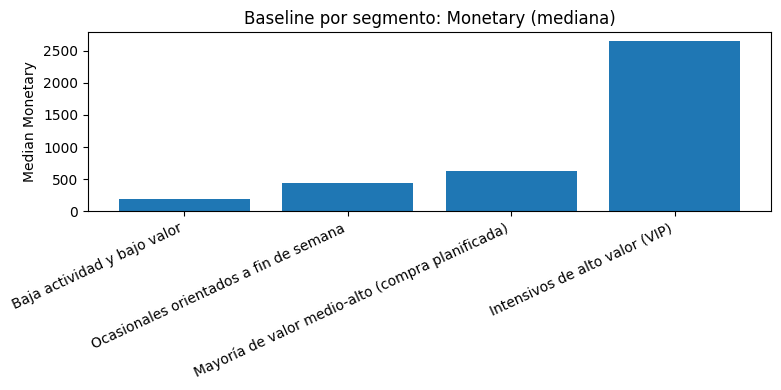

In [128]:
import matplotlib.pyplot as plt

df = tabla_711.sort_values("cluster")

plt.figure(figsize=(8,4))
plt.bar(df["segmento"], df["median_monetary"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("Median Monetary")
plt.title("Baseline por segmento: Monetary (mediana)")
plt.tight_layout()
plt.show()


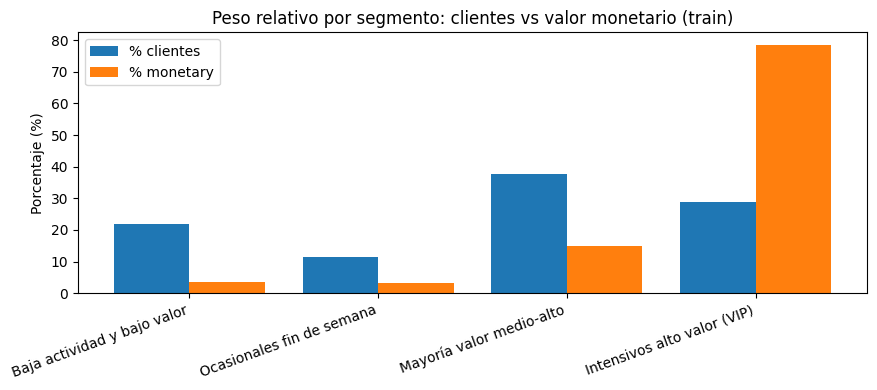

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert "df_train_clusters" in globals(), "No existe df_train_clusters."
assert "cluster_kmeans" in df_train_clusters.columns, "No existe la columna cluster_kmeans."
assert "monetary" in df_train_clusters.columns, "No existe la columna monetary."

segment_name = {
    0: "Baja actividad y bajo valor",
    1: "Ocasionales fin de semana",
    2: "Mayoría valor medio-alto",
    3: "Intensivos alto valor (VIP)"
}

g = df_train_clusters.groupby("cluster_kmeans").agg(
    n_clients=("cluster_kmeans", "size"),
    monetary_sum=("monetary", "sum")
).reset_index().rename(columns={"cluster_kmeans": "cluster"})

g["segmento"] = g["cluster"].map(segment_name)
g["pct_clients"] = g["n_clients"] / g["n_clients"].sum() * 100
g["pct_monetary"] = g["monetary_sum"] / g["monetary_sum"].sum() * 100

g = g.sort_values("cluster")

x = np.arange(len(g))
plt.figure(figsize=(9,4))
plt.bar(x - 0.2, g["pct_clients"], width=0.4, label="% clientes")
plt.bar(x + 0.2, g["pct_monetary"], width=0.4, label="% monetary")
plt.xticks(x, g["segmento"], rotation=20, ha="right")
plt.ylabel("Porcentaje (%)")
plt.title("Peso relativo por segmento: clientes vs valor monetario (train)")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-1577900288.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


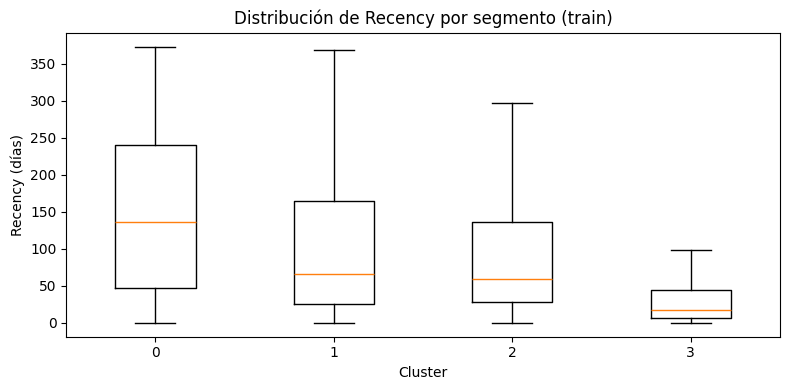

In [130]:
import matplotlib.pyplot as plt

assert "recency_days" in df_train_clusters.columns, "No existe recency_days."

data = []
labels = []
for c in sorted(df_train_clusters["cluster_kmeans"].unique()):
    vals = df_train_clusters.loc[df_train_clusters["cluster_kmeans"]==c, "recency_days"].dropna()
    data.append(vals)
    labels.append(str(c))

plt.figure(figsize=(8,4))
plt.boxplot(data, labels=labels, showfliers=False)
plt.xlabel("Cluster")
plt.ylabel("Recency (días)")
plt.title("Distribución de Recency por segmento (train)")
plt.tight_layout()
plt.show()


/tmp/ipython-input-2857413038.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


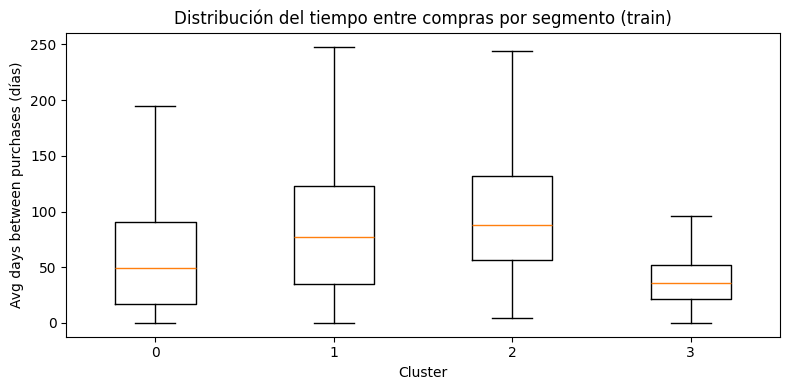

In [131]:
import matplotlib.pyplot as plt

assert "avg_days_between_purchases" in df_train_clusters.columns, "No existe avg_days_between_purchases."

data = []
labels = []
for c in sorted(df_train_clusters["cluster_kmeans"].unique()):
    vals = df_train_clusters.loc[df_train_clusters["cluster_kmeans"]==c, "avg_days_between_purchases"].dropna()
    data.append(vals)
    labels.append(str(c))

plt.figure(figsize=(8,4))
plt.boxplot(data, labels=labels, showfliers=False)
plt.xlabel("Cluster")
plt.ylabel("Avg days between purchases (días)")
plt.title("Distribución del tiempo entre compras por segmento (train)")
plt.tight_layout()
plt.show()


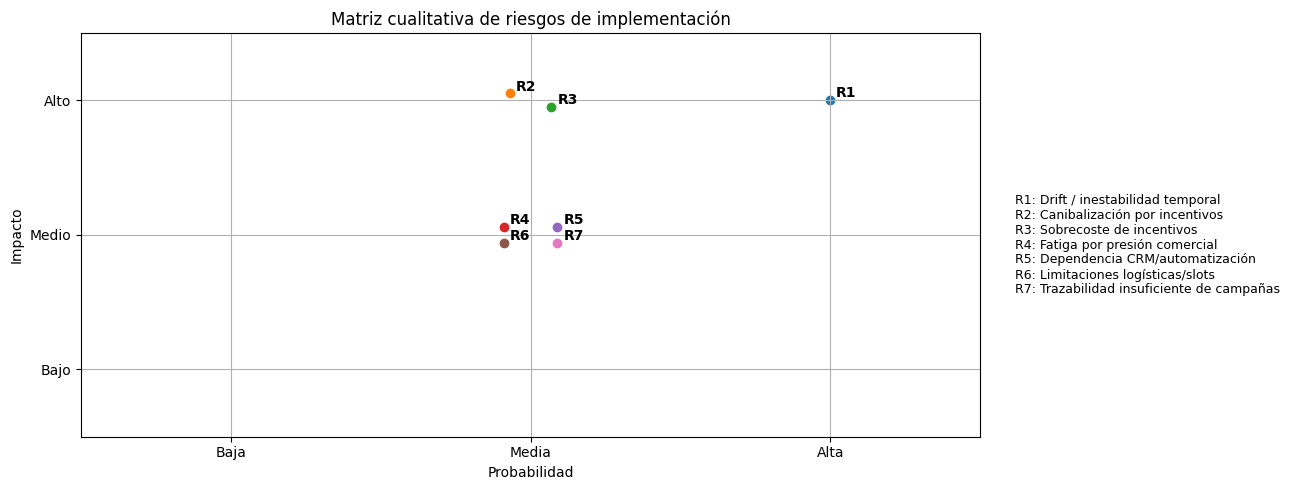

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import textwrap

# (Nombre, Probabilidad (1-3), Impacto (1-3))
riesgos = [
    ("Drift / inestabilidad temporal", 3, 3),
    ("Canibalización por incentivos", 2, 3),
    ("Sobrecoste de incentivos", 2, 3),
    ("Fatiga por presión comercial", 2, 2),
    ("Dependencia CRM/automatización", 2, 2),
    ("Limitaciones logísticas/slots", 2, 2),
    ("Trazabilidad insuficiente de campañas", 2, 2),
]

# Asignamos IDs R1..Rn
riesgos_id = [(f"R{i+1}", r[0], r[1], r[2]) for i, r in enumerate(riesgos)]

# Contamos cuántos hay en cada celda (prob, imp) para aplicar offsets
cell_counts = Counter((prob, imp) for _, _, prob, imp in riesgos_id)
cell_seen = defaultdict(int)

def offsets_for_n(n):
    # offsets pequeños para separar puntos dentro de la misma celda
    if n == 1:
        return [(0.0, 0.0)]
    if n == 2:
        return [(-0.07, 0.05), (0.07, -0.05)]
    if n == 3:
        return [(-0.08, 0.06), (0.08, 0.06), (0.0, -0.08)]
    if n == 4:
        return [(-0.09, 0.06), (0.09, 0.06), (-0.09, -0.06), (0.09, -0.06)]
    # para >4, distribuimos en círculo
    ang = np.linspace(0, 2*np.pi, n, endpoint=False)
    return [(0.10*np.cos(a), 0.10*np.sin(a)) for a in ang]

# Precalculamos offsets por celda
offset_map = {cell: offsets_for_n(n) for cell, n in cell_counts.items()}

plt.figure(figsize=(10, 5))
ax = plt.gca()

# Dibujamos puntos + etiqueta corta (R1, R2...)
for rid, name, prob, imp in riesgos_id:
    cell = (prob, imp)
    idx = cell_seen[cell]
    cell_seen[cell] += 1
    dx, dy = offset_map[cell][idx]

    x = prob + dx
    y = imp + dy

    ax.scatter(x, y)  # sin fijar colores: default
    ax.text(x + 0.02, y + 0.02, rid, fontsize=10, weight="bold")

# Ejes y formato
ax.set_xlim(0.5, 3.5)
ax.set_ylim(0.5, 3.5)
ax.set_xticks([1, 2, 3])
ax.set_yticks([1, 2, 3])
ax.set_xticklabels(["Baja", "Media", "Alta"])
ax.set_yticklabels(["Bajo", "Medio", "Alto"])
ax.set_xlabel("Probabilidad")
ax.set_ylabel("Impacto")
ax.set_title("Matriz cualitativa de riesgos de implementación")
ax.grid(True)
plt.tight_layout()

# Leyenda textual a la derecha (lista de riesgos)
legend_lines = []
for rid, name, _, _ in riesgos_id:
    legend_lines.append(f"{rid}: {name}")

legend_text = "\n".join(textwrap.fill(line, width=45) for line in legend_lines)

plt.gcf().text(
    1.02, 0.5, legend_text,
    va="center", ha="left", fontsize=9
)

plt.show()
